In [7]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import numpy as np

### Extract Gradients

In [6]:
## extract gradients from original xarray files and save into separate folder.
input_path = 'lustre_scratch/data/South_Africa_West_Coast/absolute'
output_path = 'lustre_scratch/data/South_Africa_West_Coast/gradient'
file_list = []
for file in os.listdir(input_path): 
    if file.endswith('.nc'): 
        file_list.append(os.path.join(input_path,file))

gradient_clipping = True # clip extreme gradients

if gradient_clipping: 
    clip_min = -1
    clip_max = 1

for file in file_list: 
    ds = xr.open_dataset(file)
    gRsst_x_grad = ds.gRsst.differentiate('x')
    gRsst_y_grad = ds.gRsst.differentiate('y')
    sstL4_x_grad = ds.sstL4.differentiate('x')
    sstL4_y_grad = ds.sstL4.differentiate('y')
    if gradient_clipping:
        gRsst_x_grad = gRsst_x_grad.clip(clip_min,clip_max)
        gRsst_y_grad = gRsst_y_grad.clip(clip_min,clip_max)
        sstL4_x_grad = sstL4_x_grad.clip(clip_min,clip_max)
        sstL4_y_grad = sstL4_y_grad.clip(clip_min,clip_max)
    ds_gRsst_grad = xr.Dataset({
        "gRsst_x_grad": gRsst_x_grad,
        "gRsst_y_grad": gRsst_y_grad
    })
    
    ds_sstL4_grad = xr.Dataset({
        "sstL4_x_grad": sstL4_x_grad,
        "sstL4_y_grad": sstL4_y_grad
    })
    ds_combined = xr.merge([ds_gRsst_grad, ds_sstL4_grad])
    ds_combined.to_netcdf(os.path.join(output_path, os.path.basename(file)))

### Extract by location
Find geographic locations with the highest number of datapoints in the dataset. 
Save an isolated dataset from a chosen 2.4x2.4 degree location.

In [9]:
data_folder="lustre_scratch/data/absolute"
counts = {}

In [12]:
file_list = []
for name in os.listdir(data_folder):
    if name.endswith('.nc'):
        path = os.path.join(data_folder,name)
        file_list.append(path) # for later use
        ds = xr.open_dataset(path)
        (n,_) = ds.lat.shape
        for i in range(n):
            # iterate through dataset, find location of each datapoint, add to bin count
            lat0 = ds.lat[i,0].item()
            lon0 = ds.lon[i,0].item()
            lat1 = ds.lat[i,-1].item()
            lon1 = ds.lon[i,-1].item()
            key = (lat0,lon0,lat1,lon1)
            if key not in counts:
                counts[key] = 0
            counts[key] = 1 + counts[key]

In [13]:
top50 = sorted(counts.items(),key=lambda t:t[1],reverse=True)[:50] # ((coords), number in bin)
top50[0][1] # top bin

400

In [15]:
## Collate and save all data from a chosen grid
index = 49 # index in top50 to create a dataset from. 0: most populated bin
dataset_name = 'Test'
output_path = 'lustre_scratch/data/Test'
grid, count = top50[index]
da_list = []
found_count = 0
for file in file_list:
    ds = xr.open_dataset(file)
    for i in range(len(ds.i)):
        coords = (ds.lat[i,0].item(), ds.lon[i,0].item(), ds.lat[i,-1].item(), ds.lon[i,-1].item())
        if np.all(np.isclose(coords,grid)): 
            da_list.append(ds.sel(i=i))
            found_count+=1
            if found_count == count:
                break
ds = xr.concat(da_list,dim='i')
ds.to_netcdf(output_path)
print(ds)

/tmp/ipykernel_525/2796799350.py:18: SerializationWarning: saving variable time with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds.to_netcdf(output_path)


<xarray.Dataset>
Dimensions:       (i: 237, y: 48, x: 48, s: 2)
Coordinates:
    lat           (y) float64 -44.97 -44.92 -44.88 ... -42.72 -42.67 -42.62
    lon           (x) float64 -58.97 -58.92 -58.88 ... -56.72 -56.67 -56.62
Dimensions without coordinates: i, y, x, s
Data variables: (12/18)
    mta           (i, y, x) float32 286.4 286.3 286.1 ... 278.8 278.7 278.6
    mtb           (i, y, x) float32 286.5 286.4 286.2 ... 278.8 278.7 278.7
    sstL3         (i, y, x) float32 286.4 286.3 286.1 ... 278.8 278.7 278.6
    sstL4         (i, y, x) float32 286.3 286.3 286.2 ... 278.9 278.9 279.0
    usstL4        (i, y, x) float32 0.4 0.41 0.41 0.41 ... 0.55 0.56 0.57 0.58
    sensitivity   (i) float64 0.9664 0.928 0.9574 ... 0.9708 0.9549 0.9654
    ...            ...
    corrab        (i) float64 0.9834 0.9865 0.9843 0.9912 ... 0.9891 0.97 0.9813
    corr34        (i) float64 0.9581 0.9564 0.9731 ... 0.9679 0.965 0.9767
    finlier       (i) float64 1.0 1.0 0.9987 0.9909 ... 0.9983 0.98

In [97]:
ds.to_netcdf('lustre_scratch/data/South_Africa_West_Coast/absolute/SA_absolutes.nc')

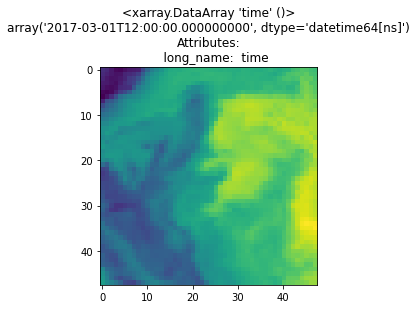

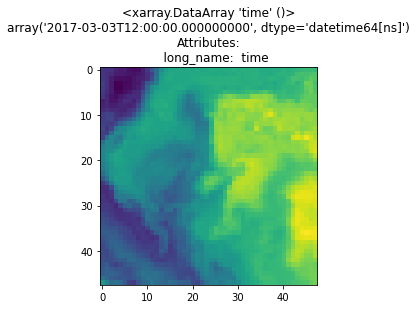

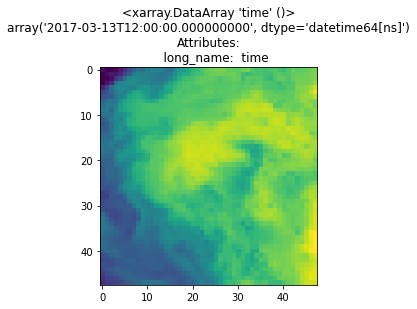

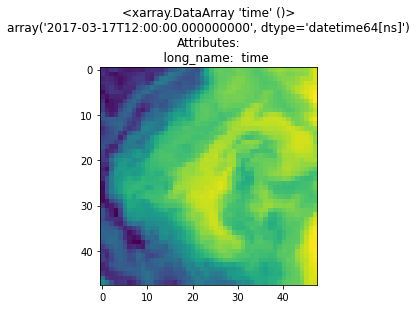

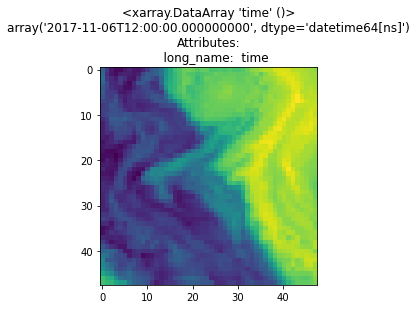

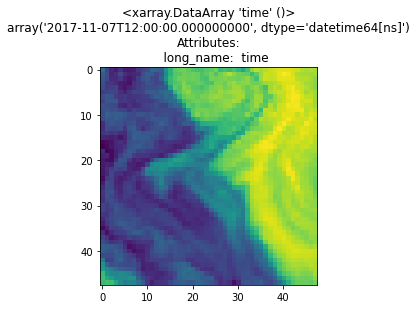

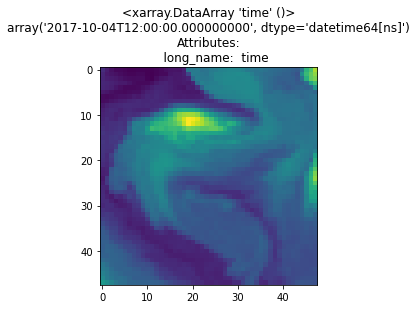

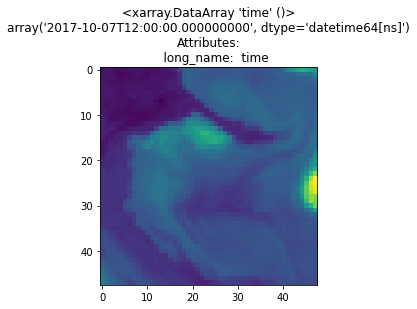

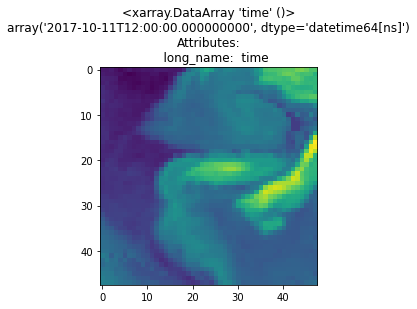

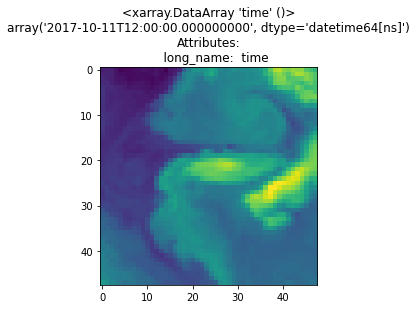

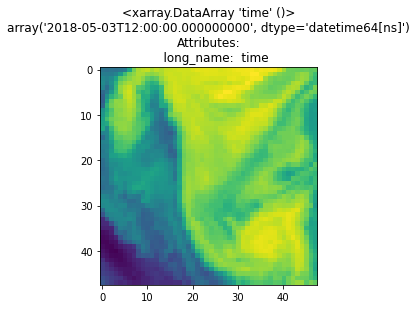

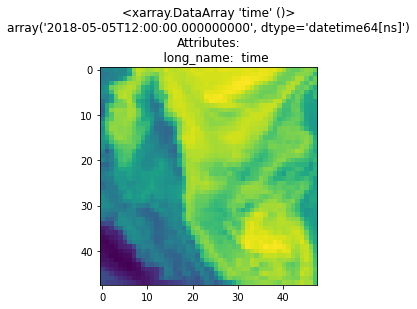

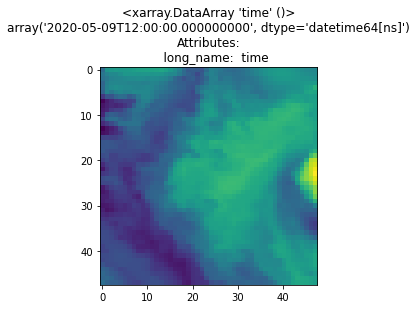

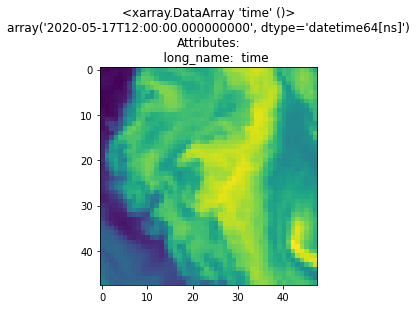

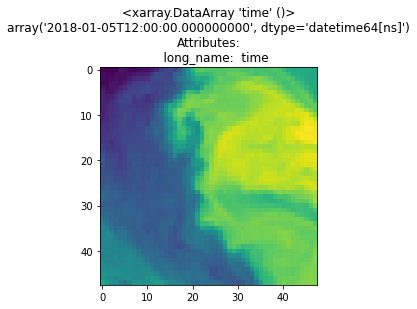

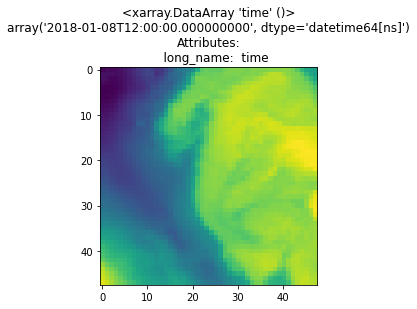

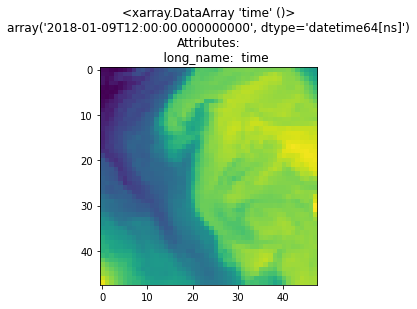

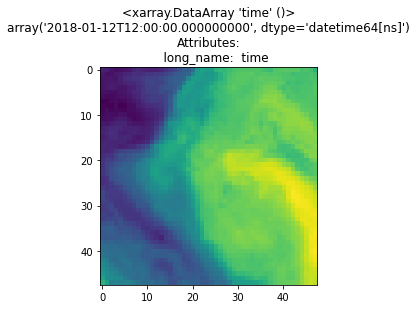

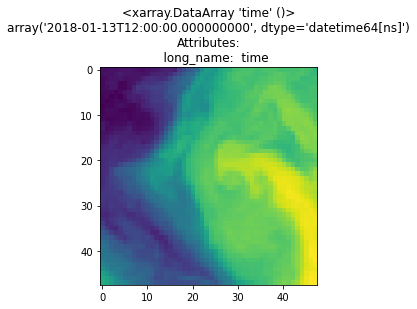

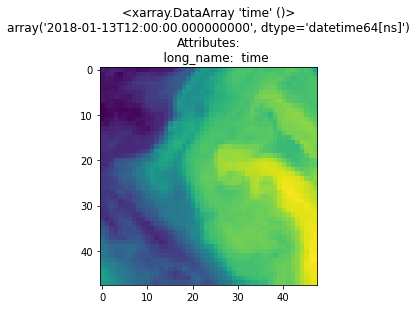

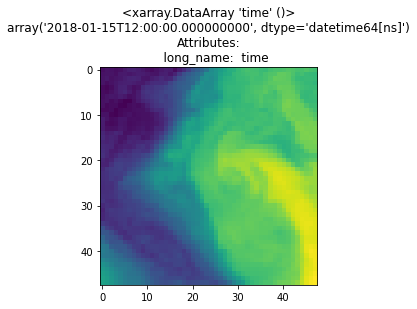

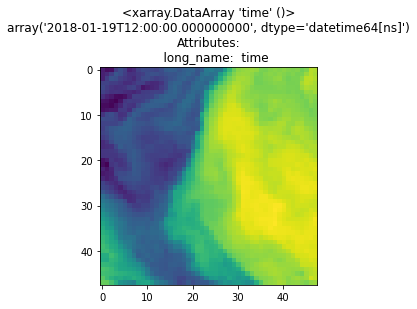

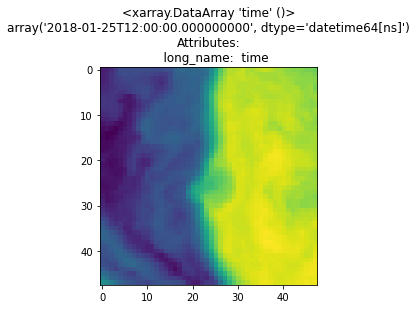

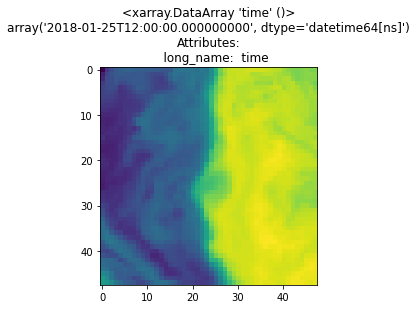

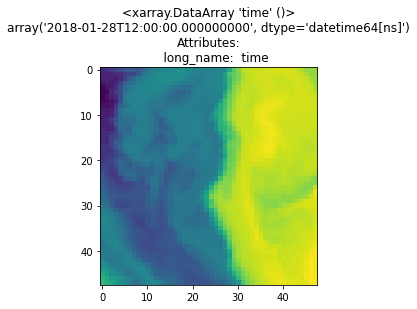

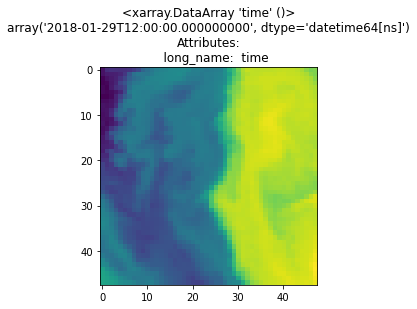

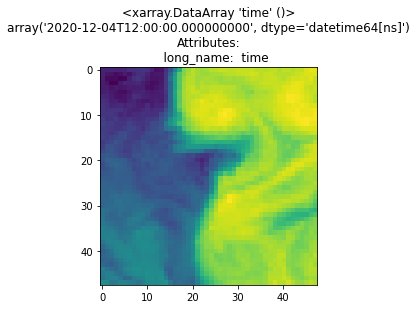

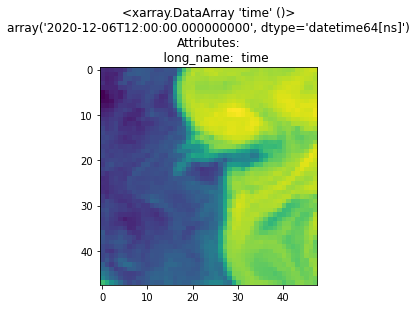

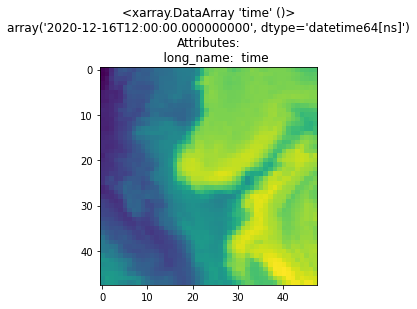

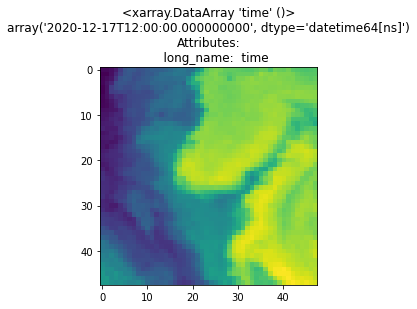

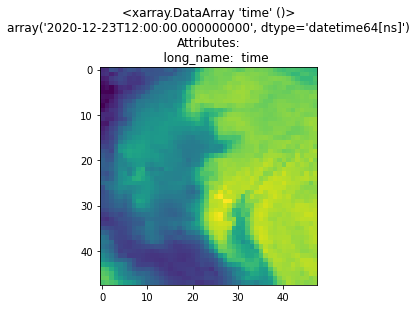

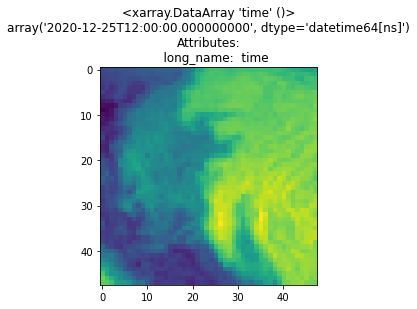

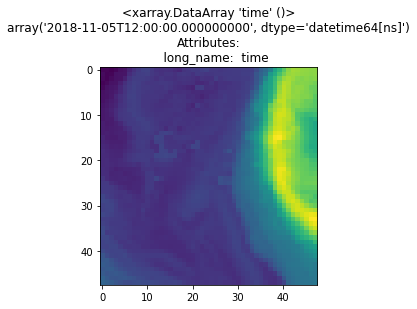

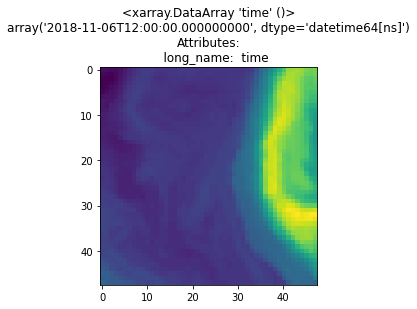

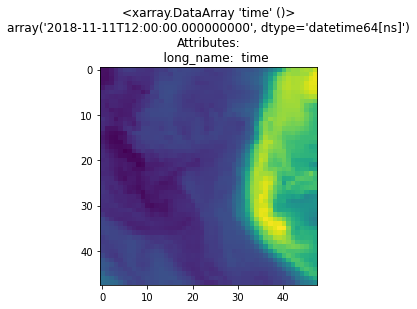

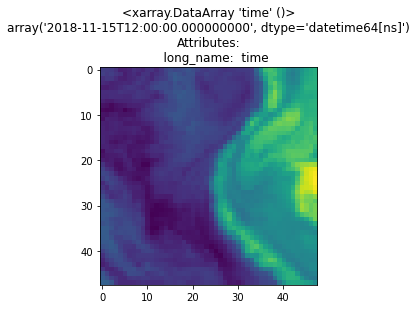

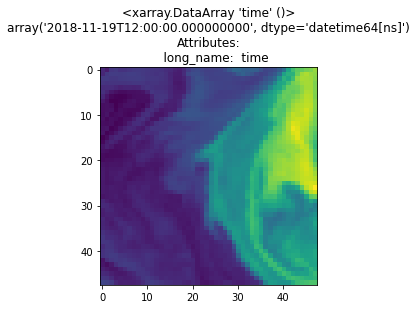

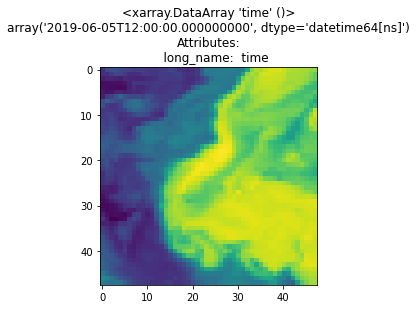

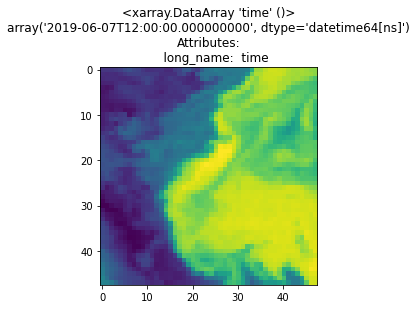

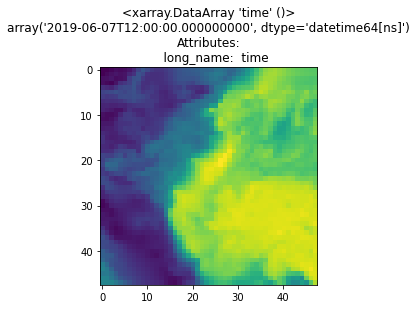

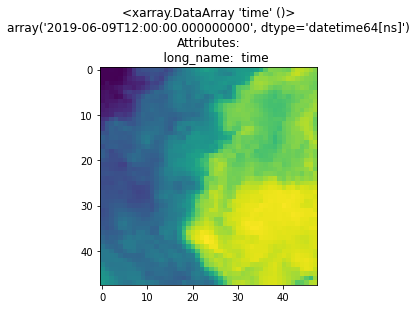

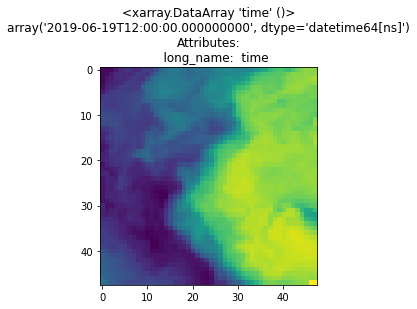

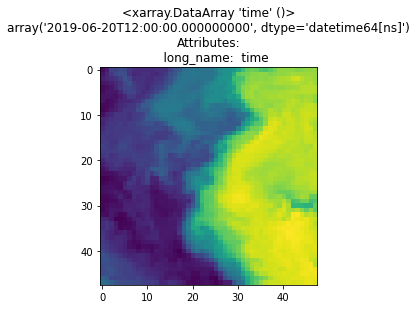

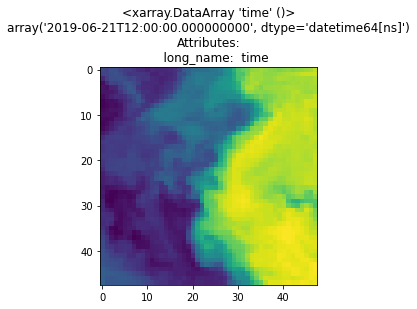

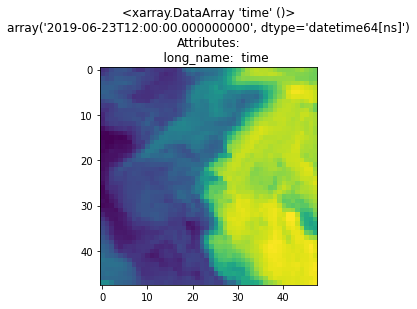

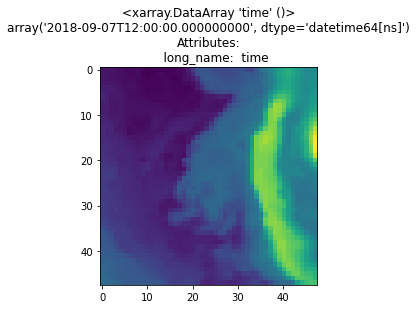

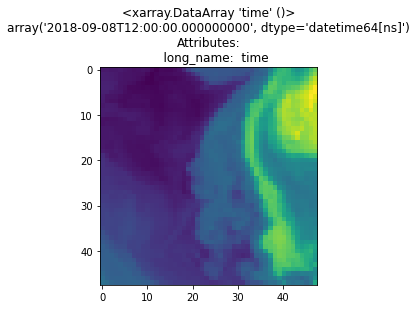

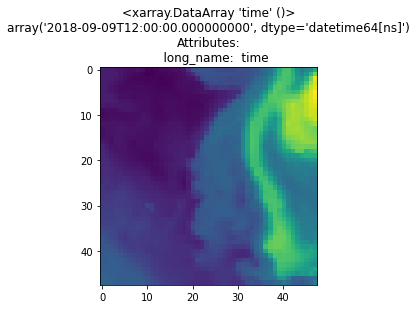

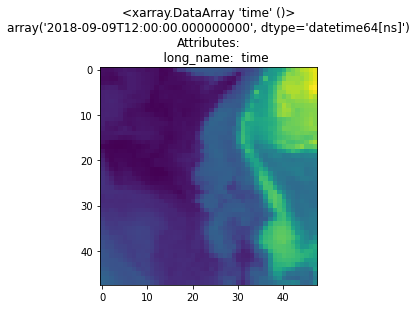

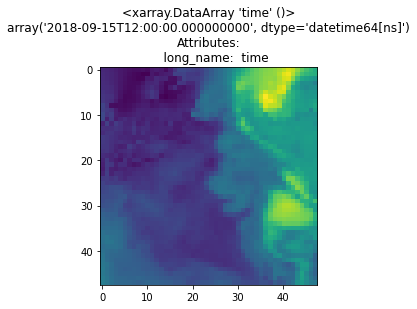

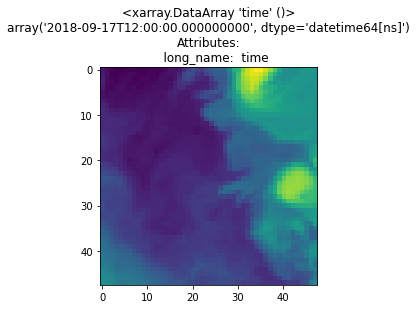

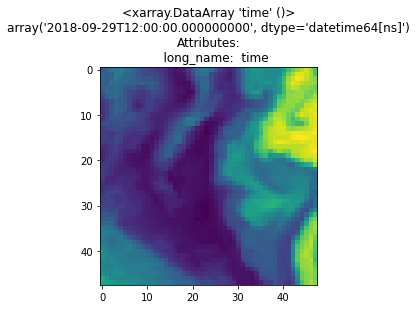

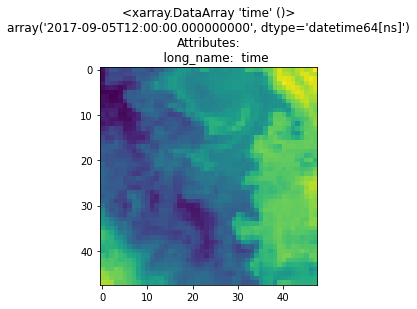

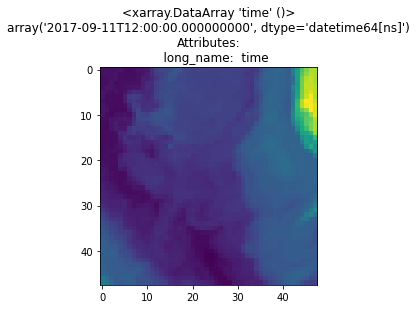

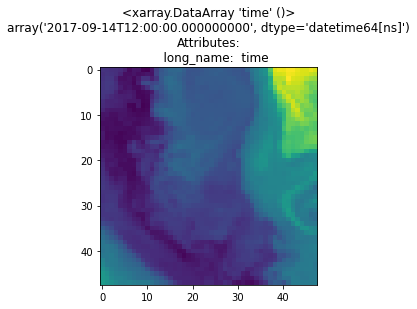

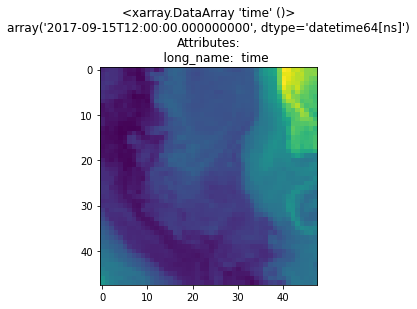

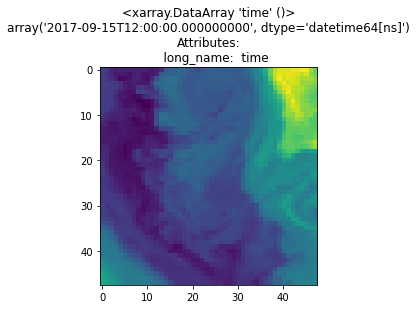

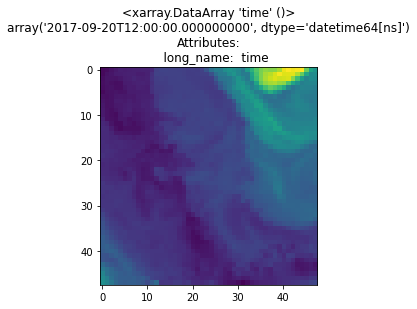

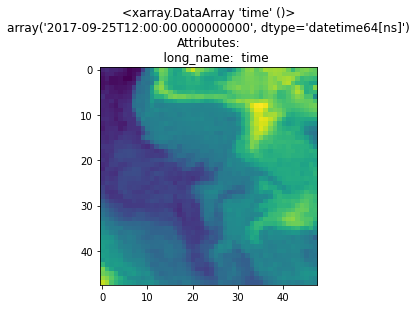

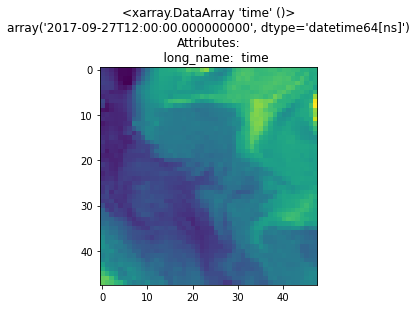

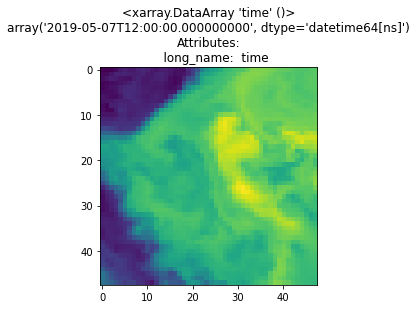

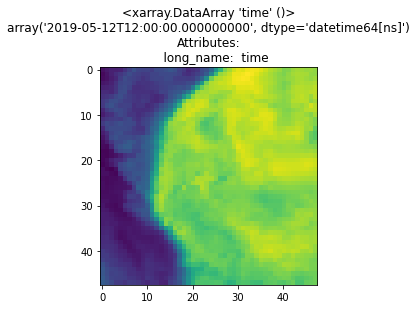

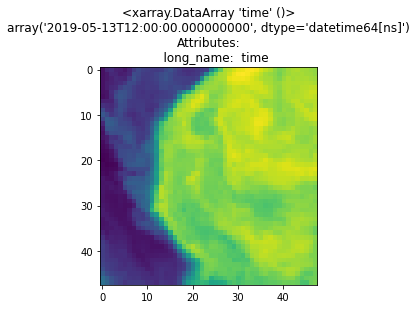

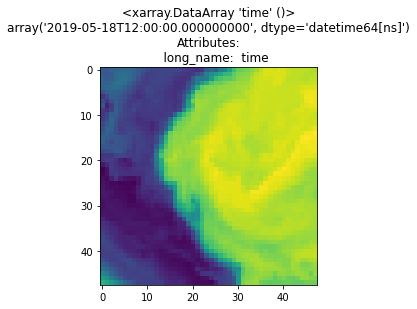

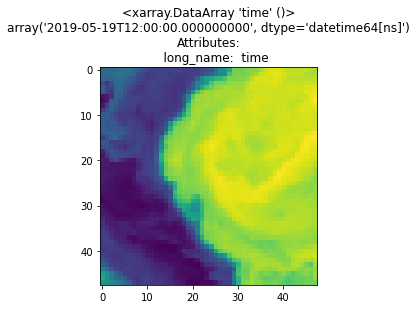

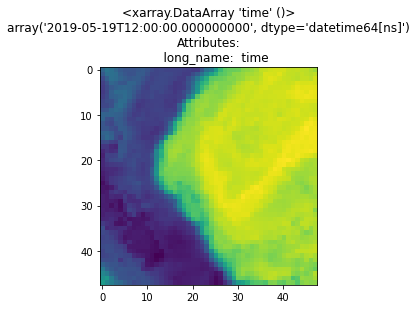

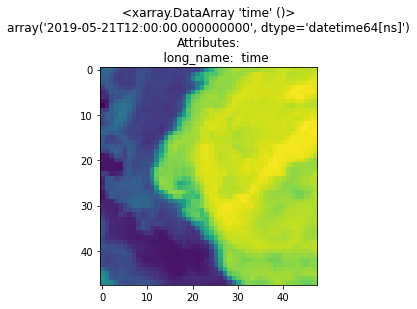

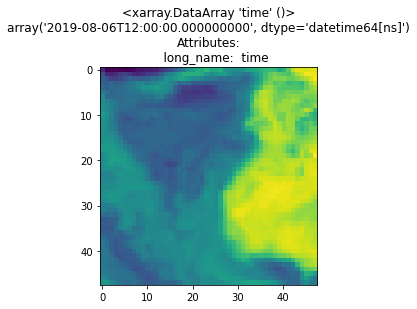

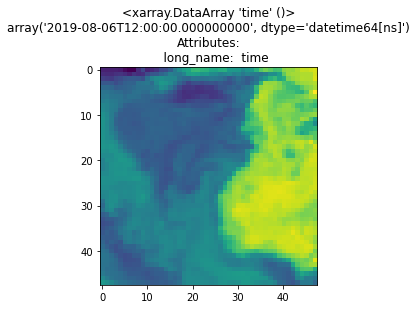

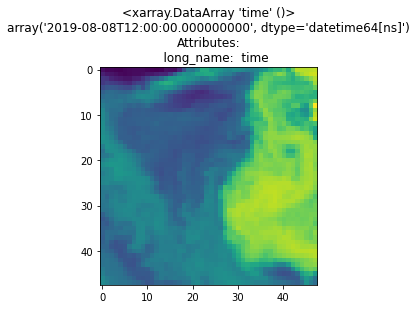

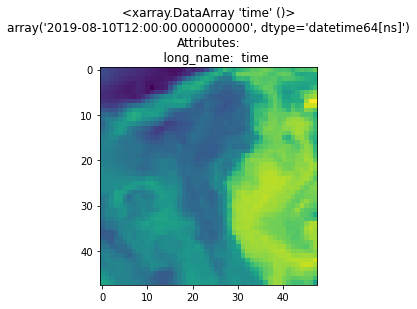

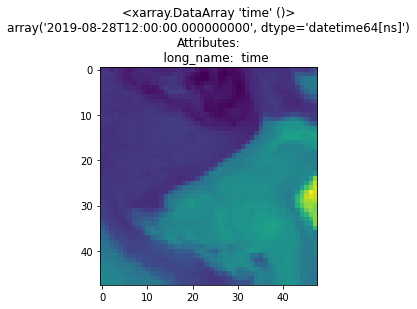

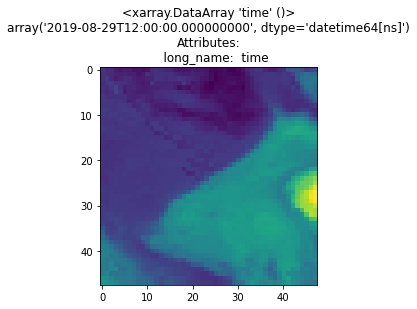

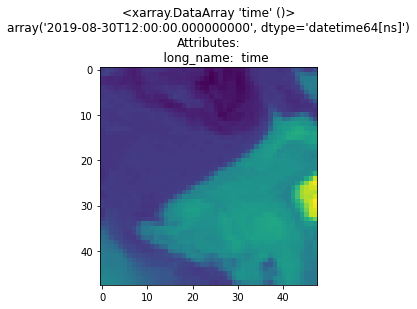

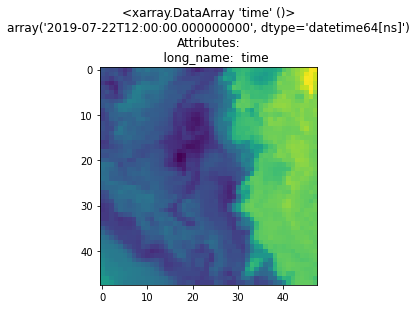

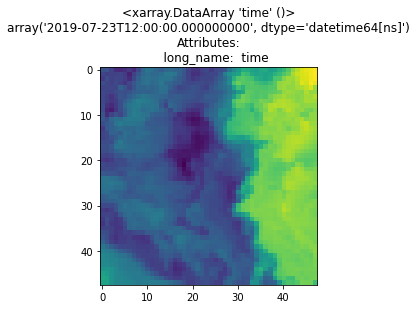

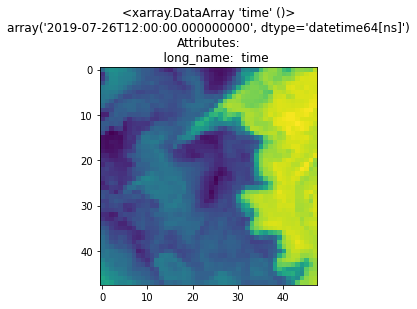

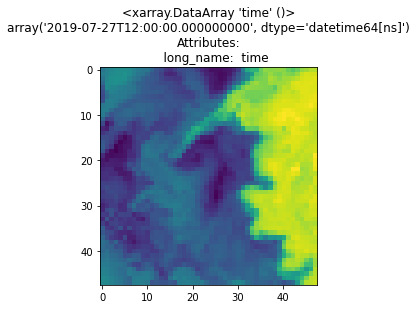

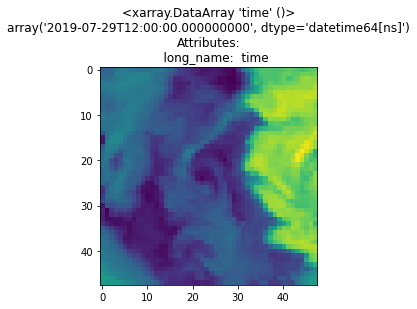

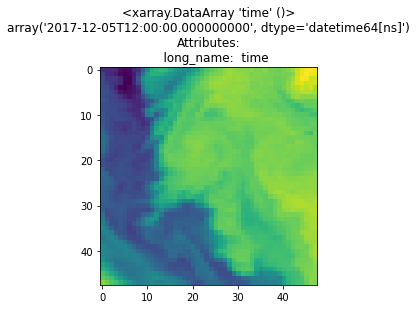

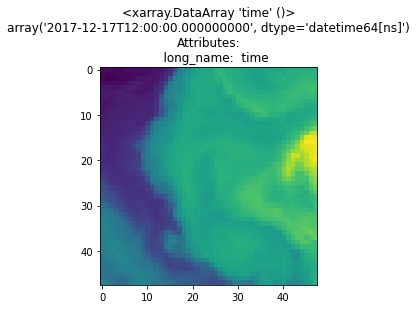

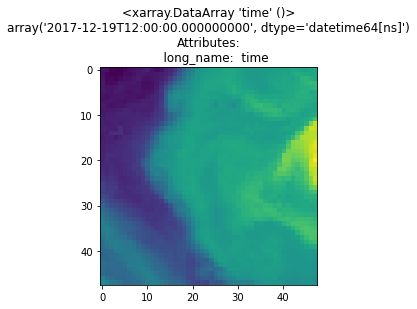

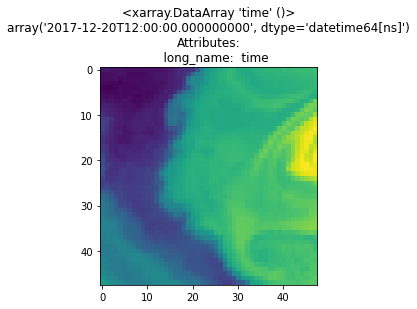

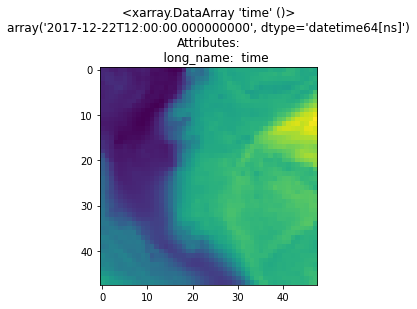

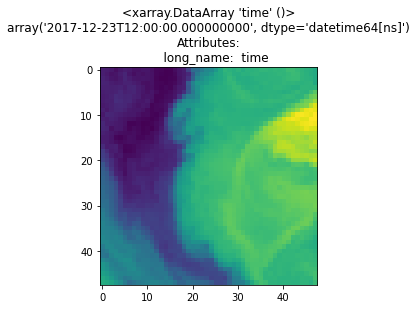

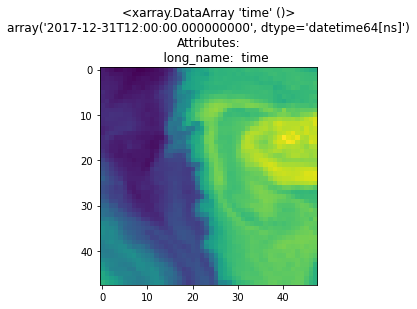

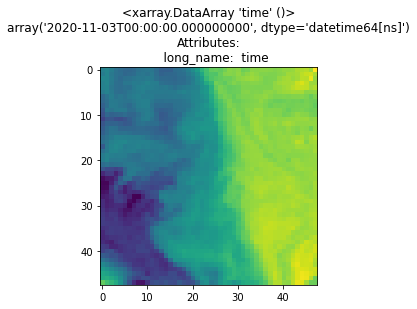

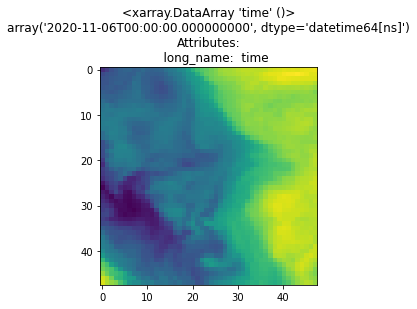

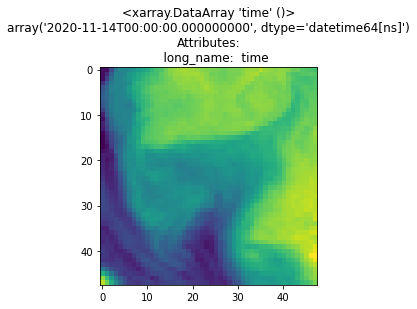

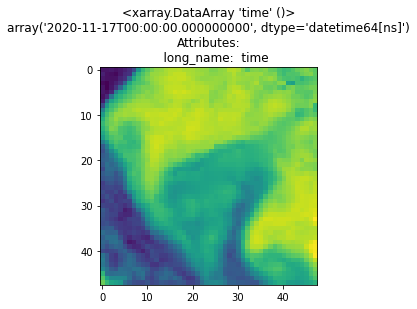

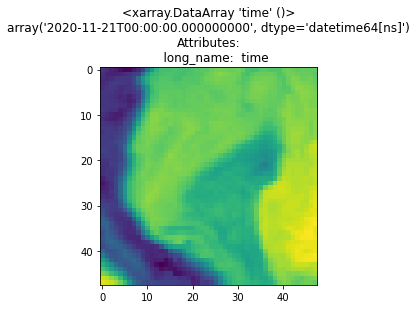

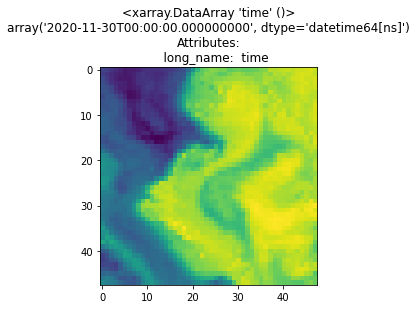

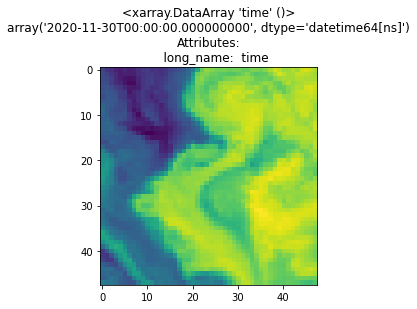

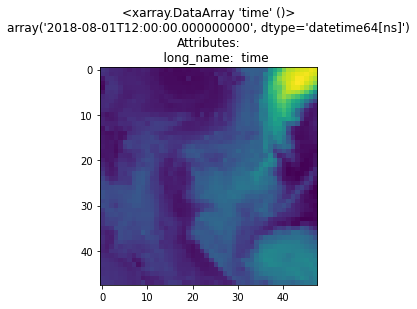

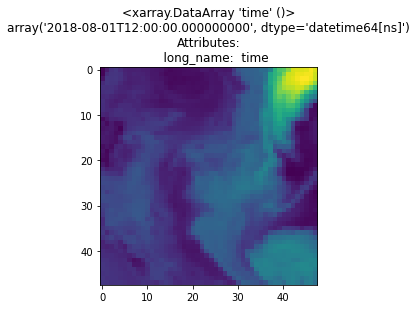

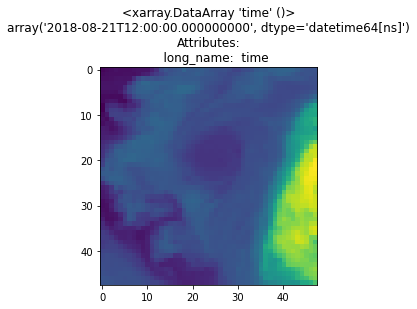

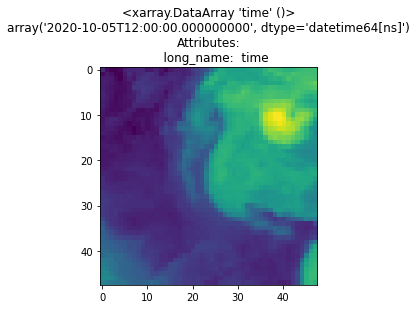

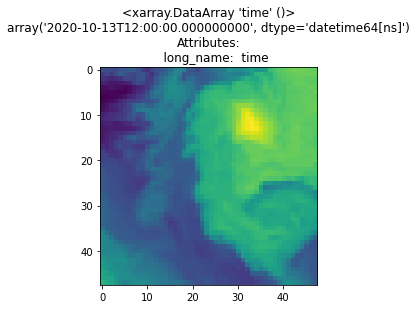

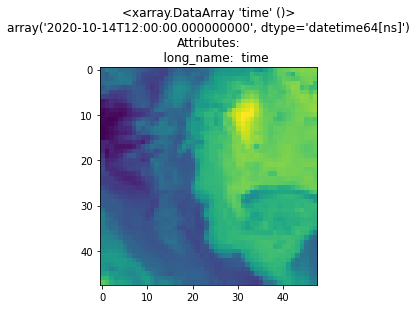

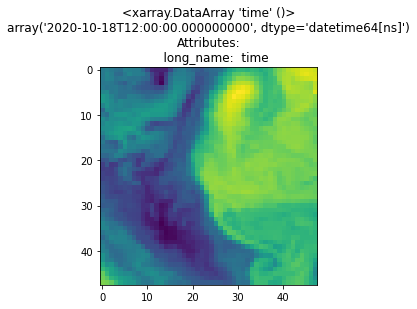

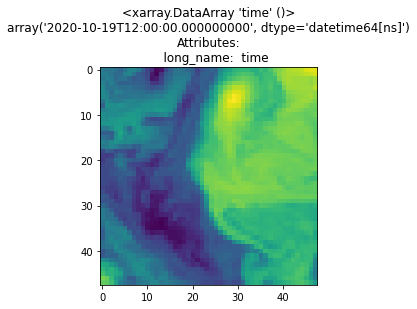

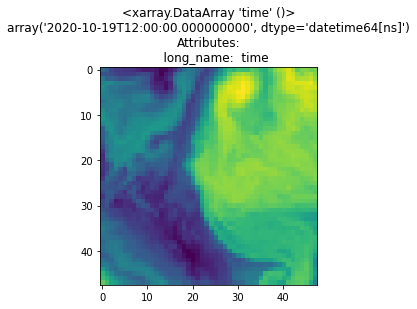

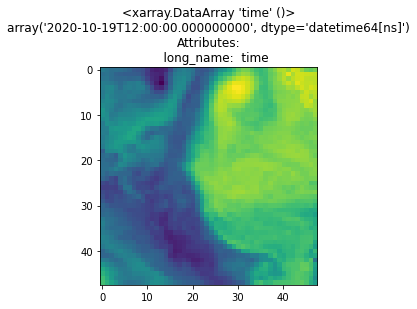

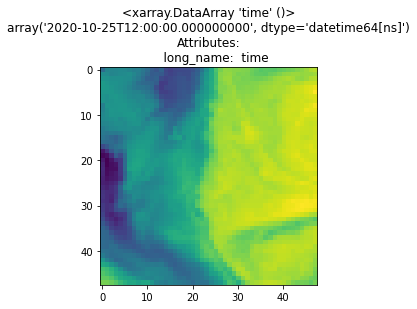

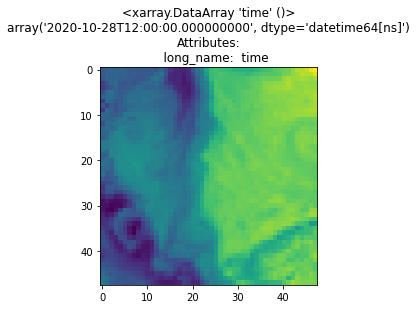

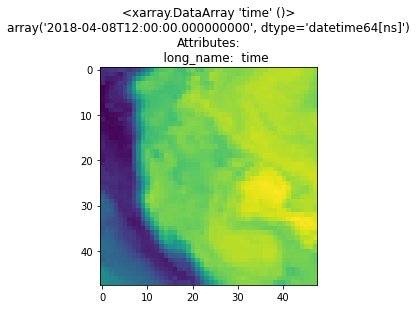

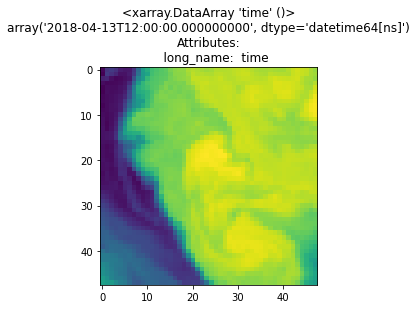

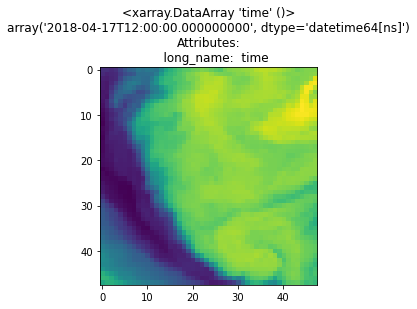

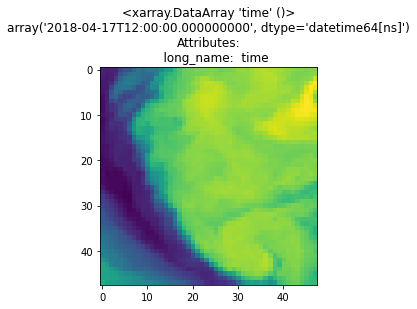

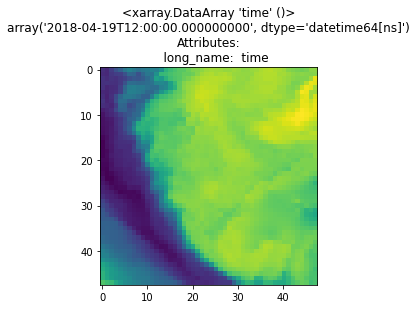

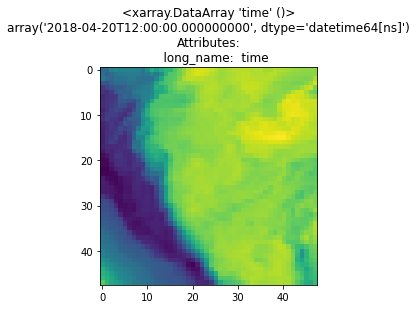

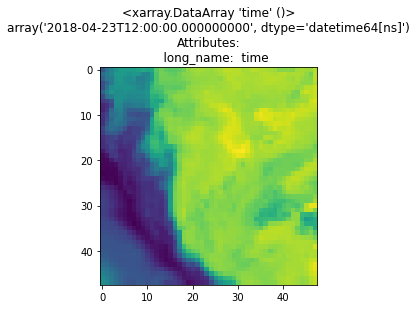

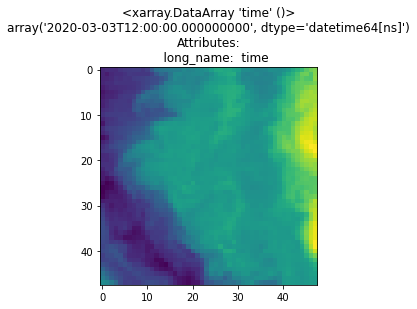

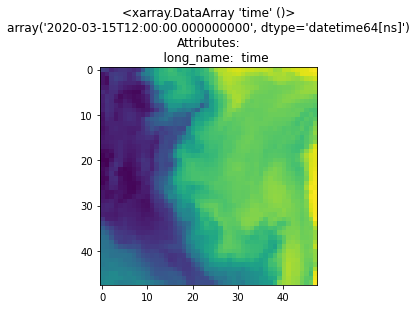

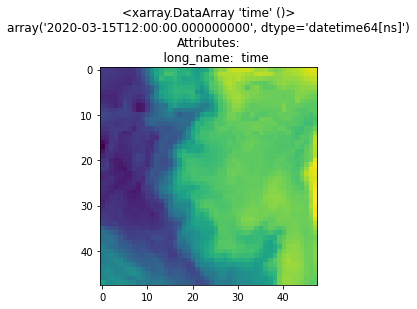

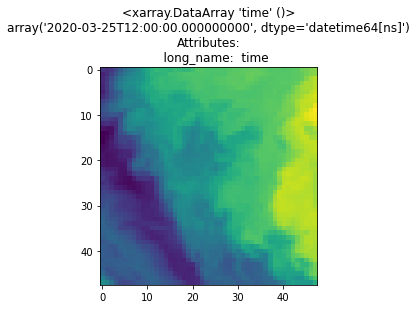

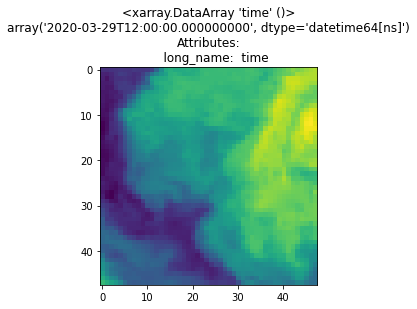

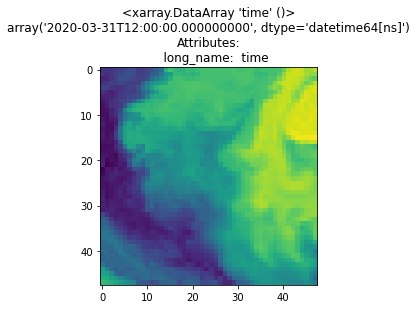

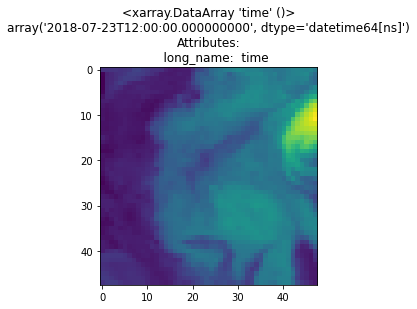

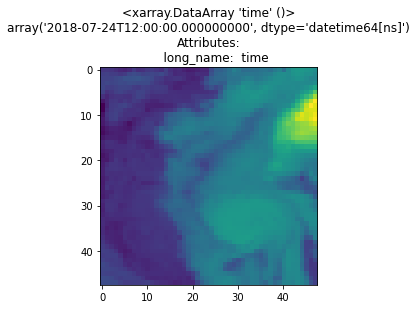

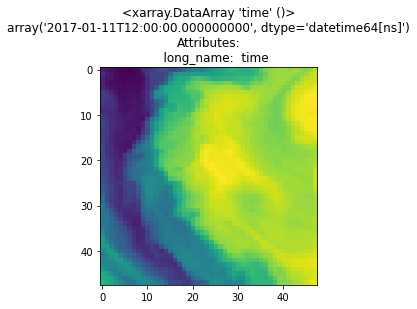

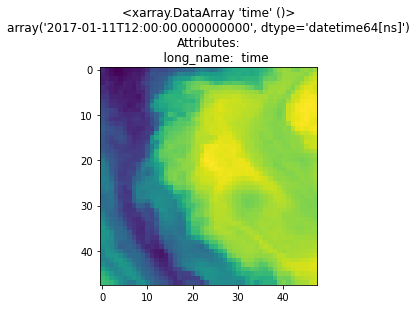

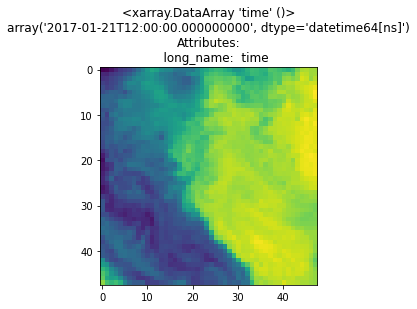

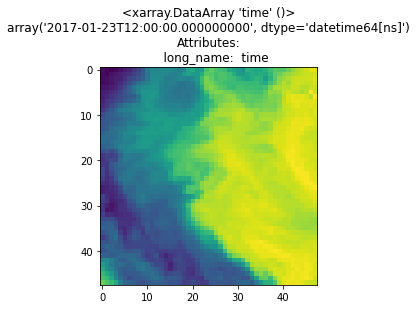

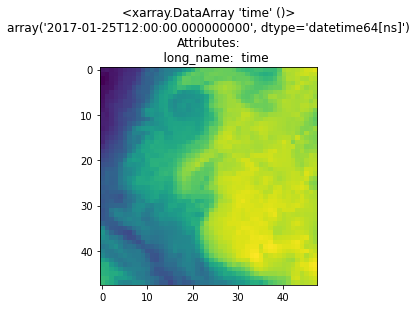

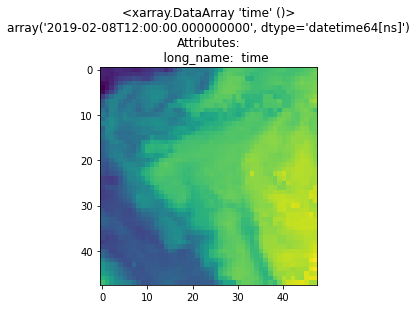

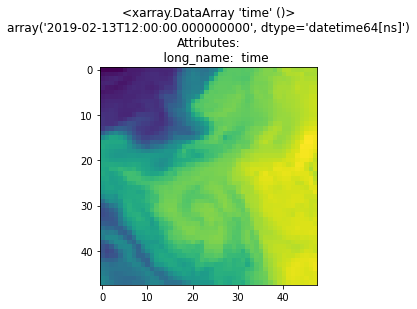

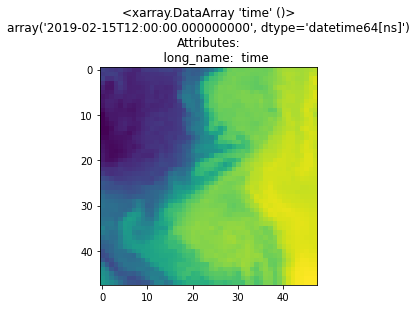

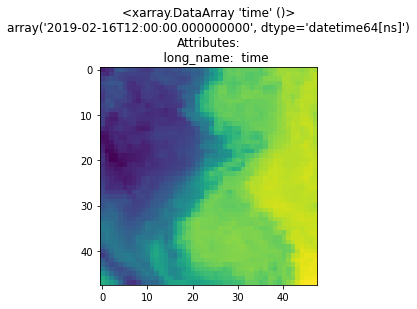

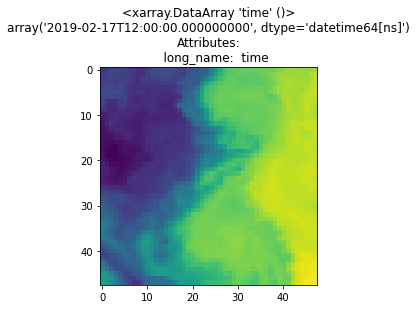

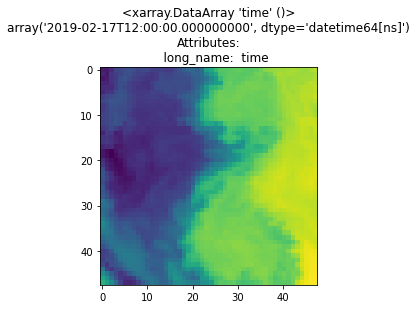

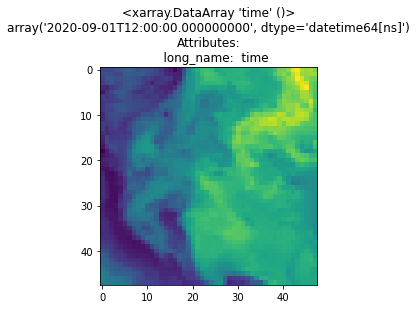

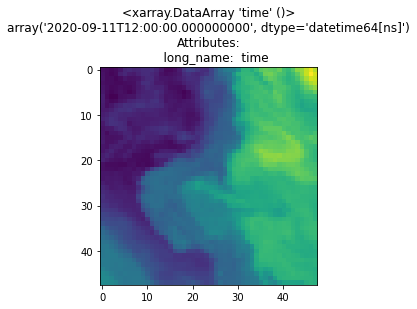

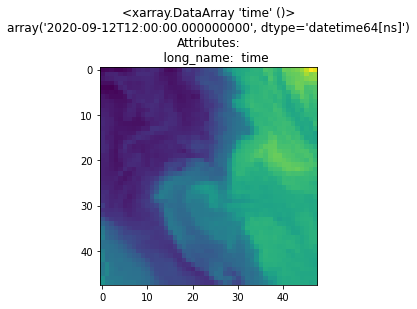

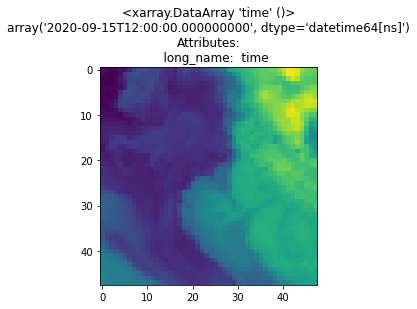

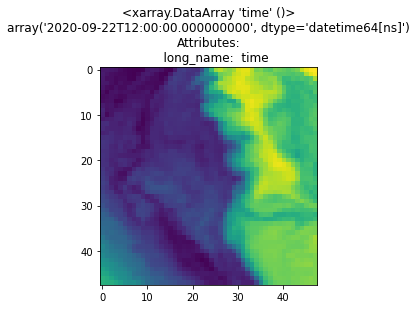

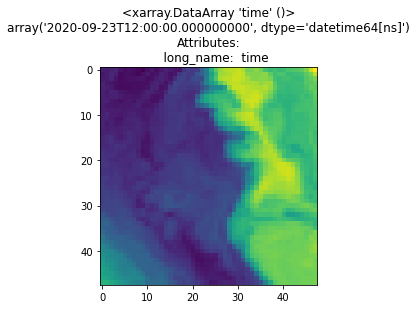

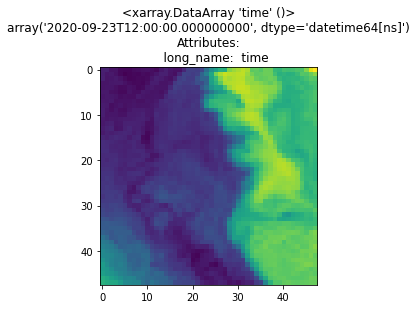

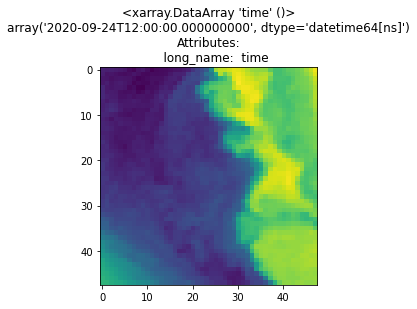

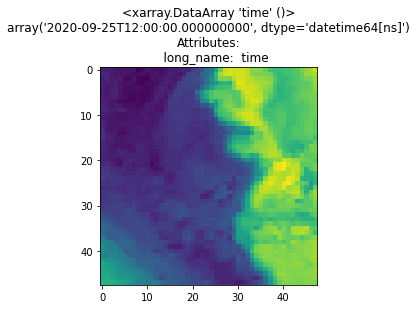

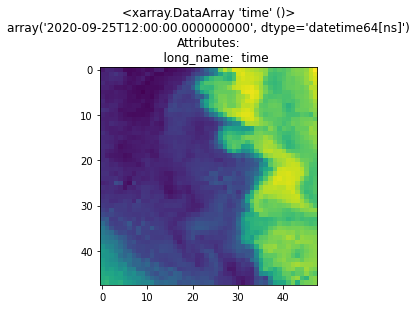

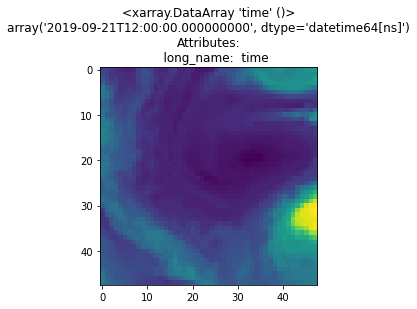

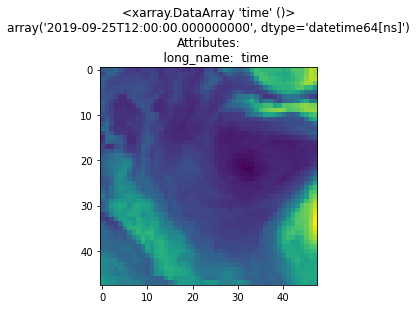

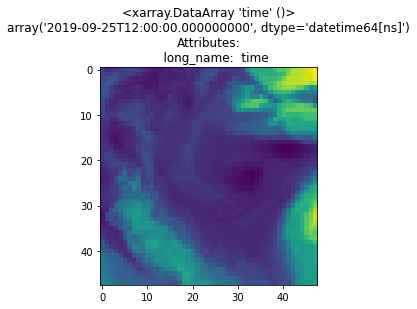

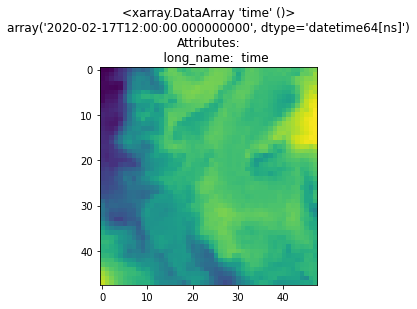

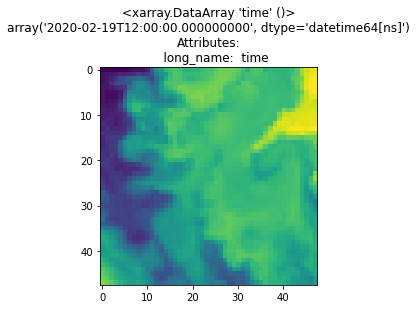

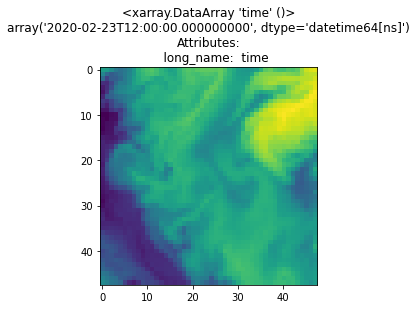

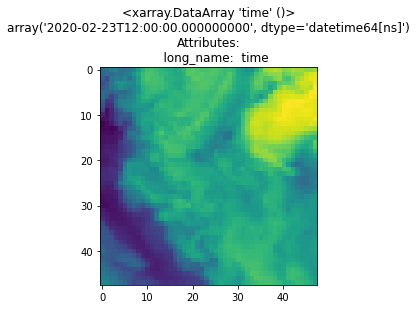

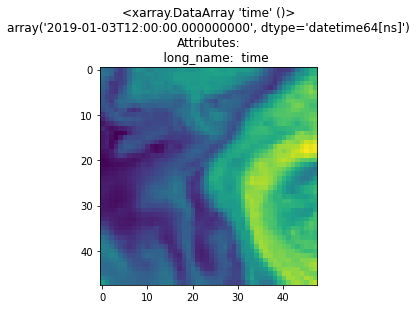

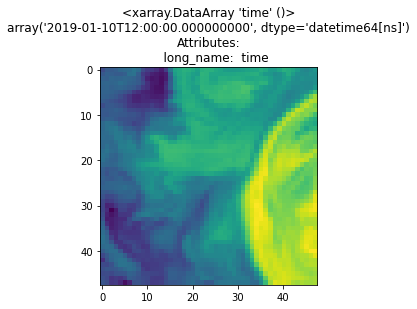

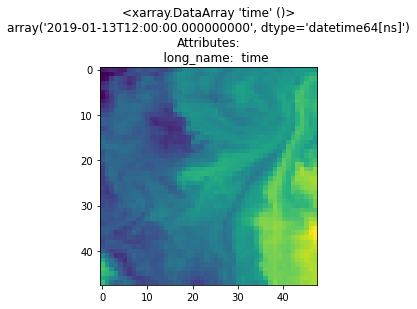

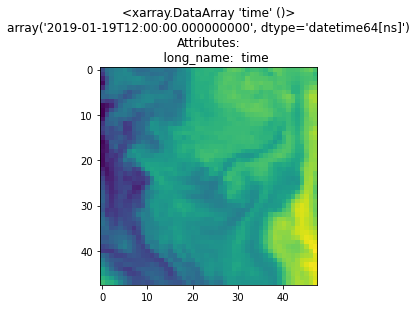

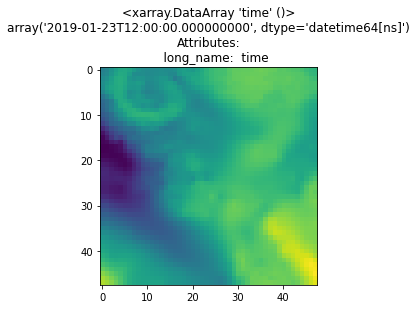

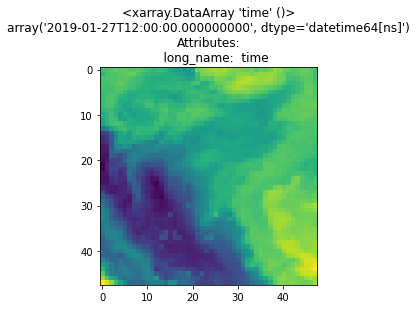

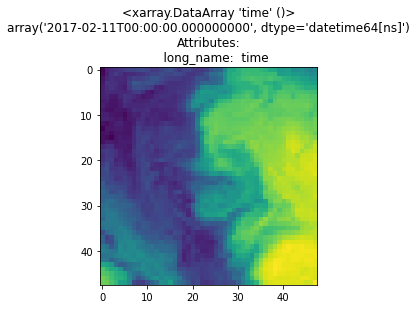

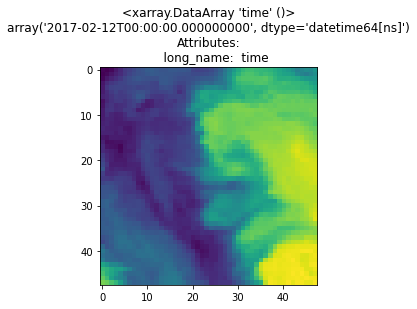

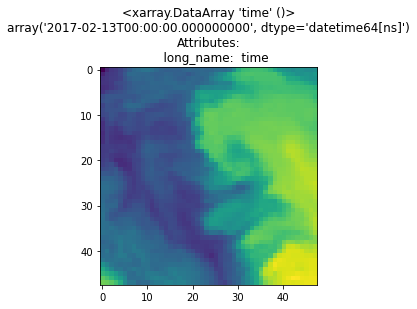

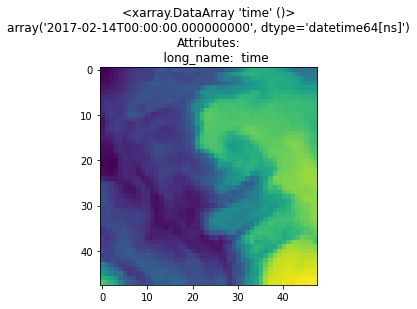

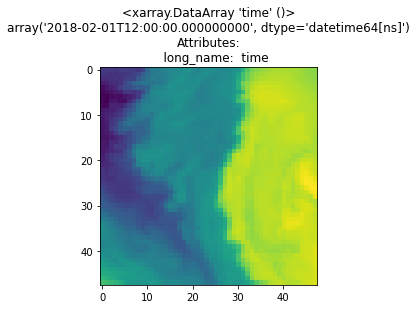

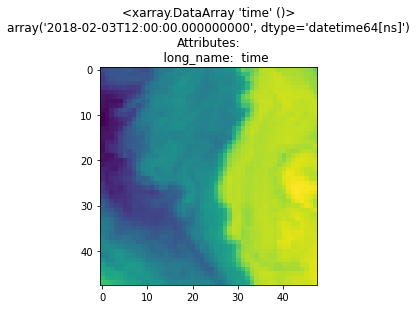

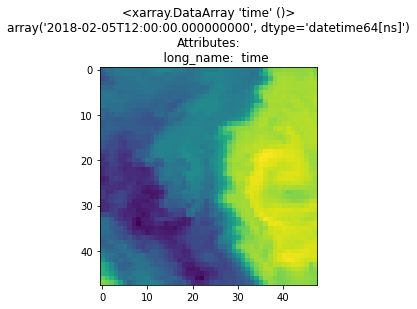

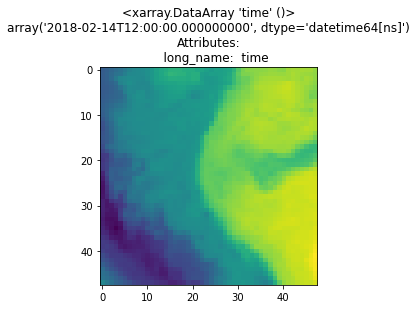

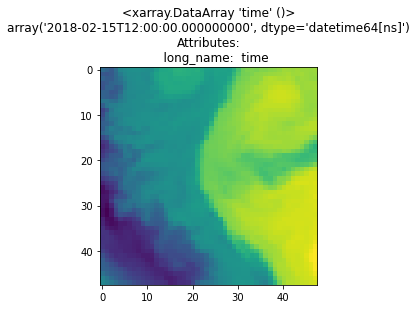

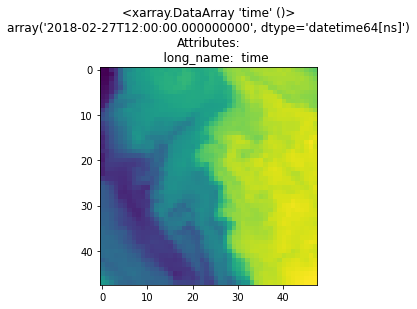

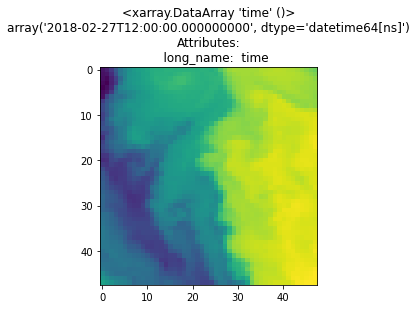

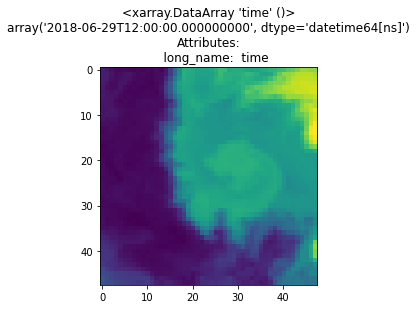

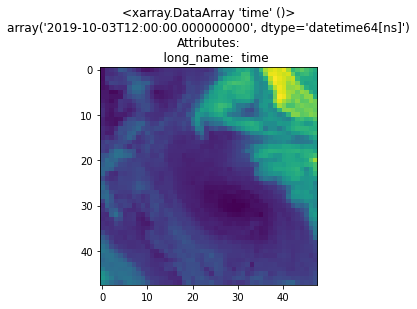

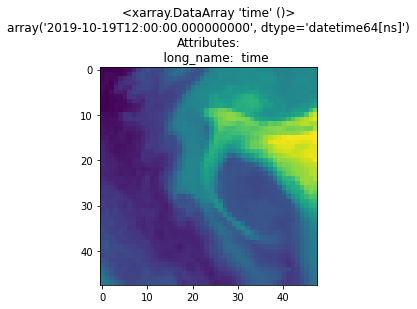

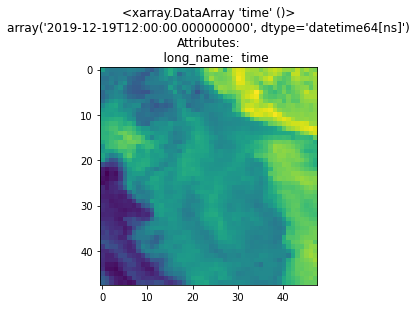

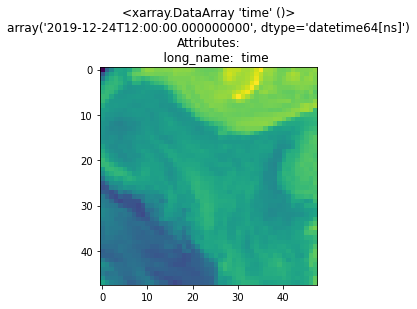

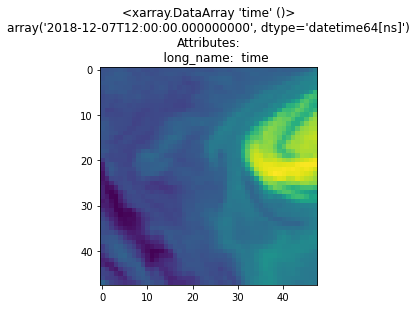

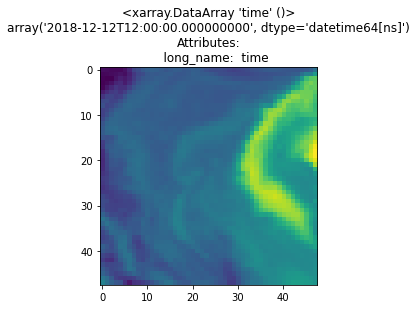

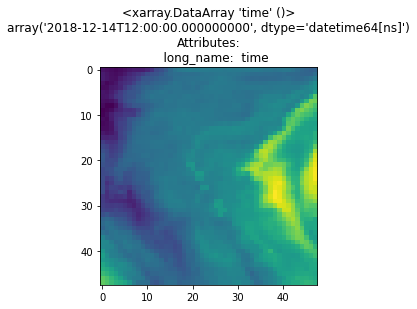

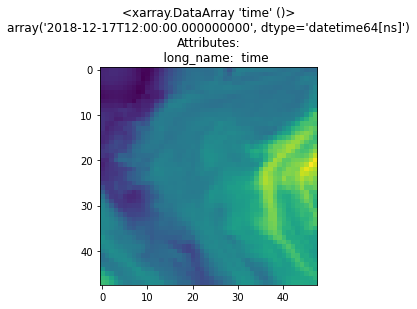

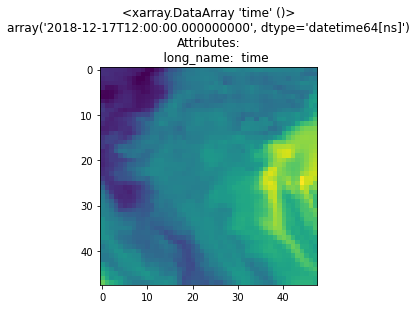

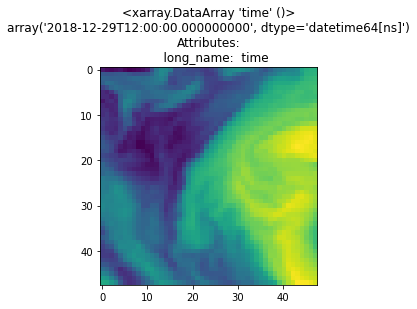

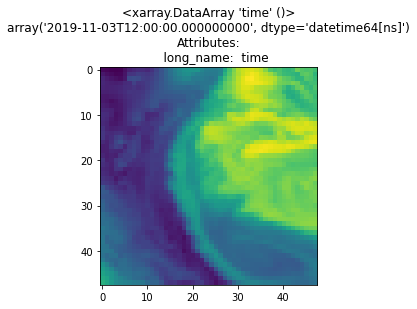

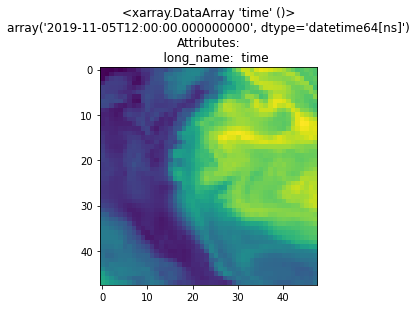

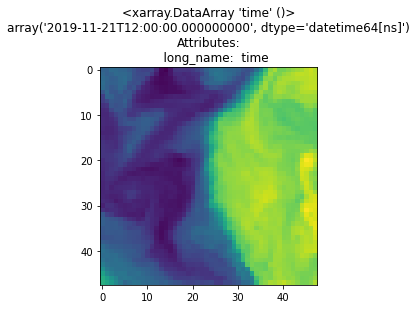

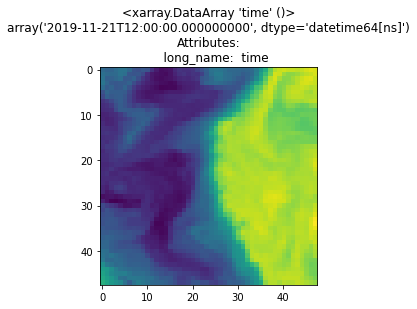

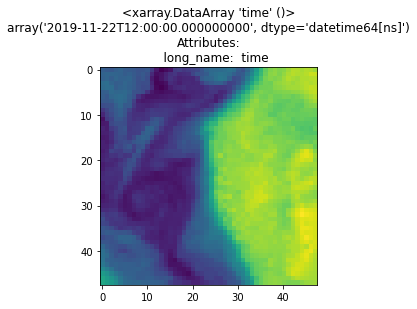

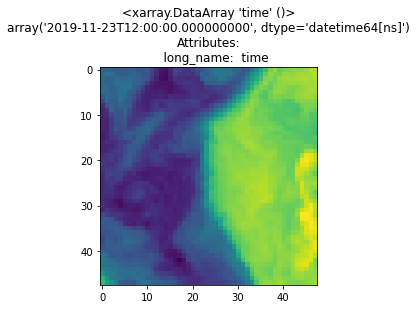

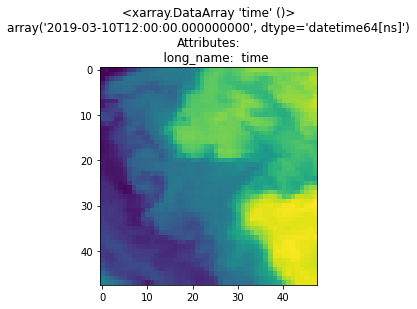

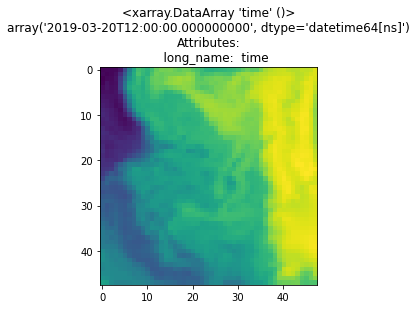

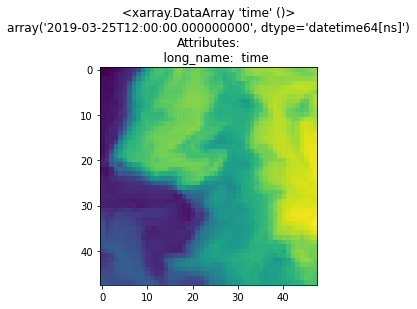

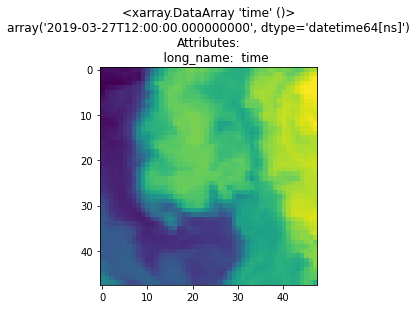

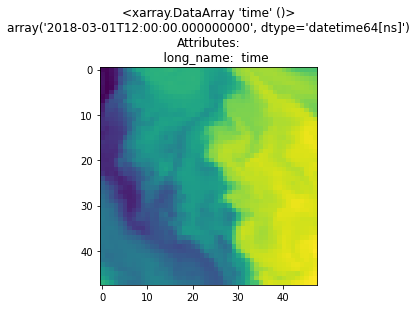

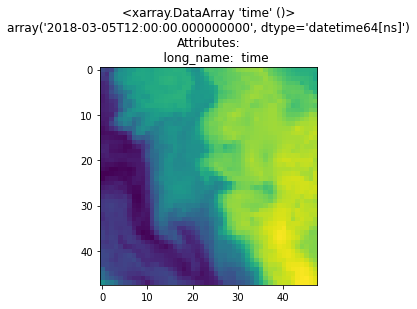

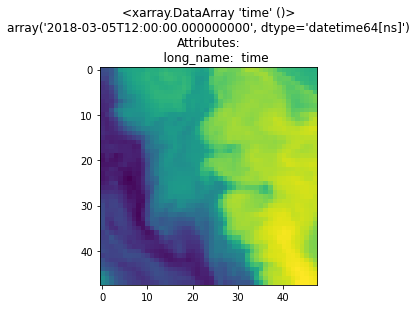

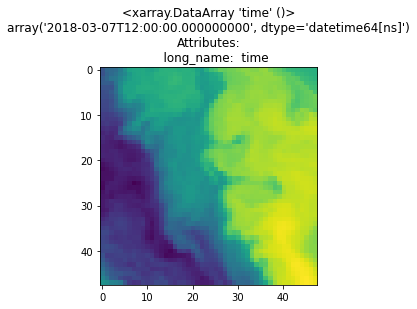

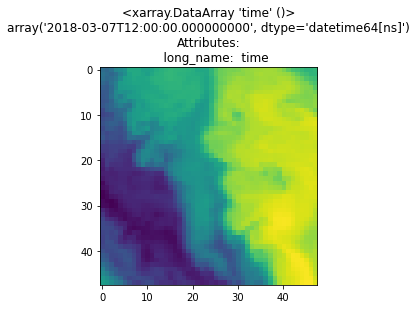

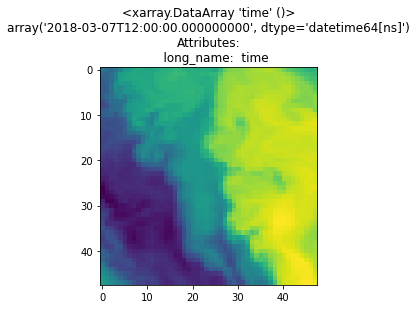

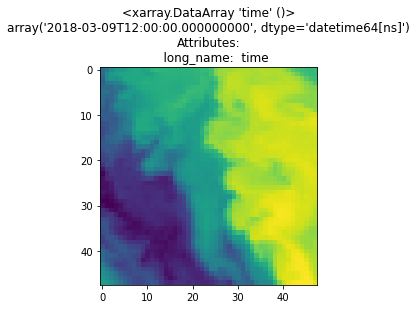

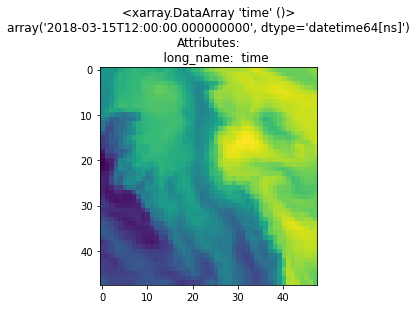

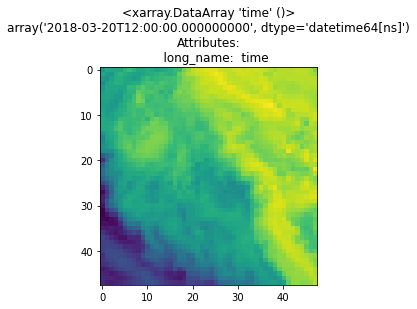

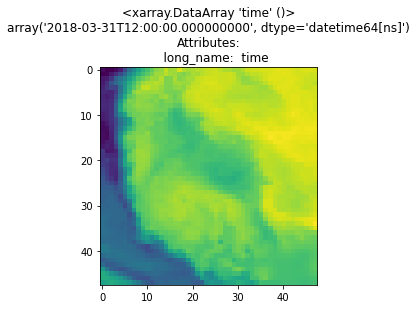

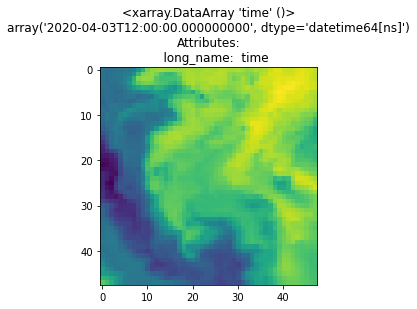

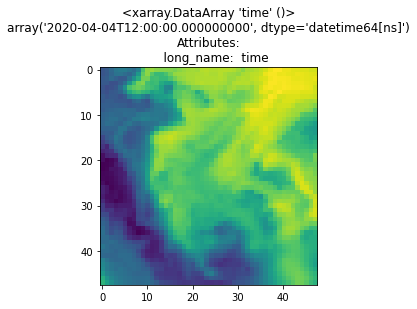

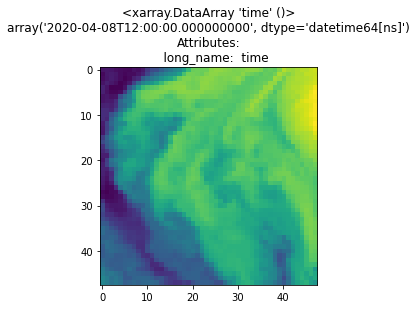

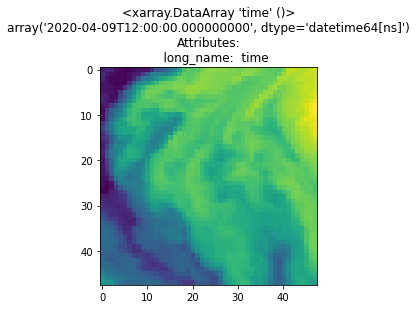

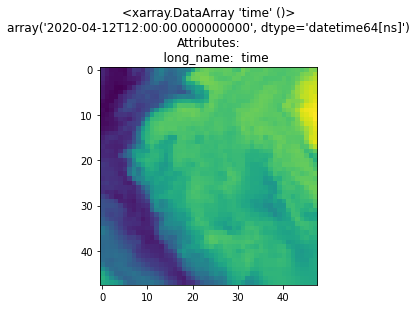

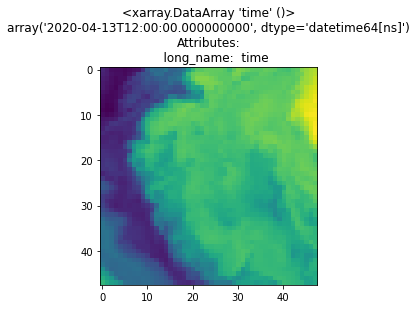

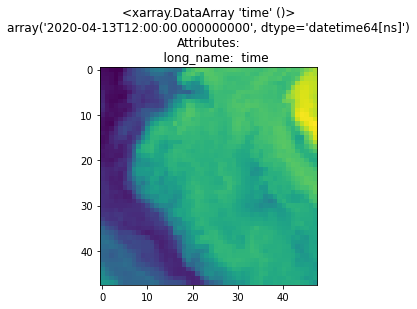

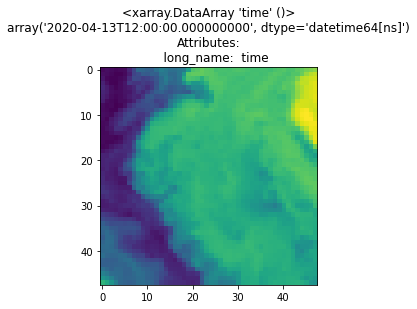

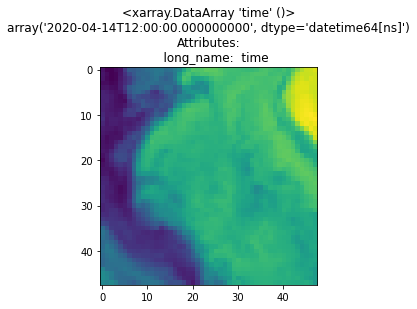

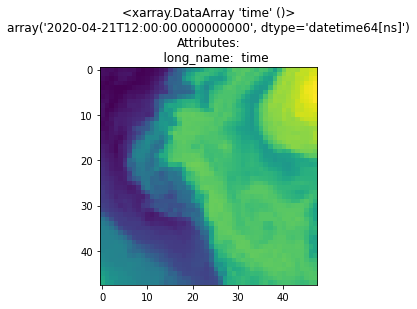

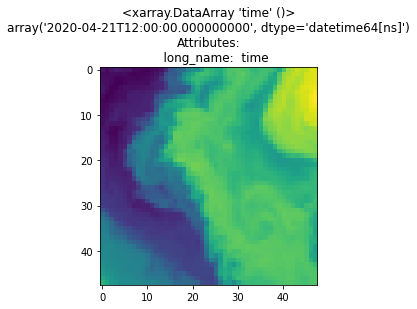

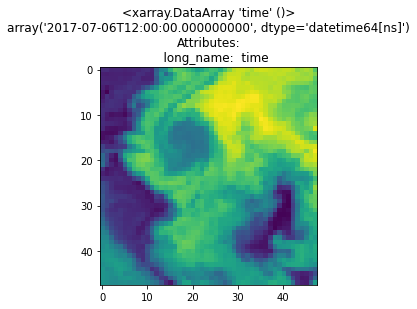

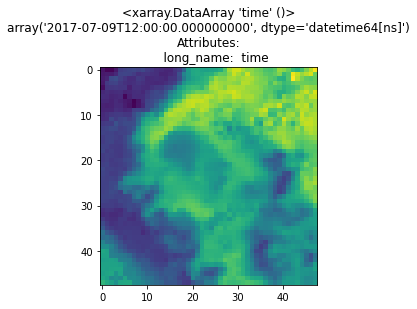

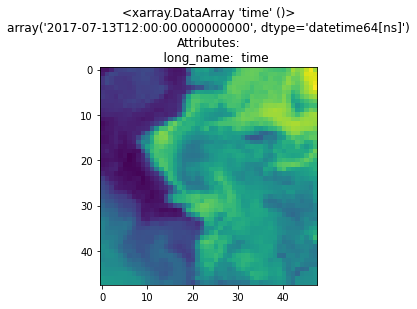

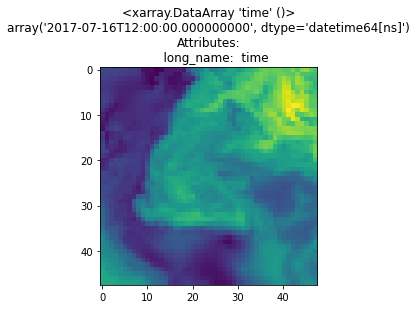

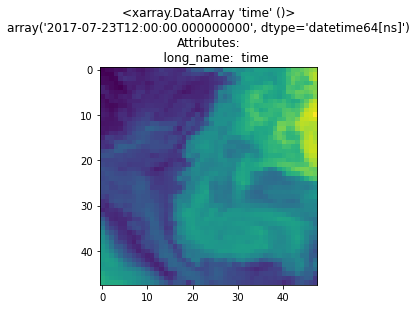

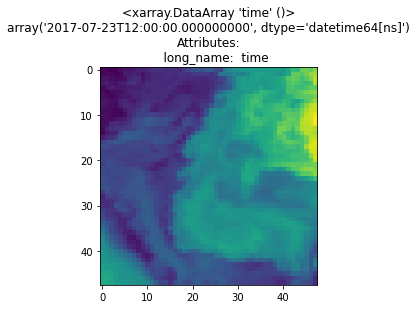

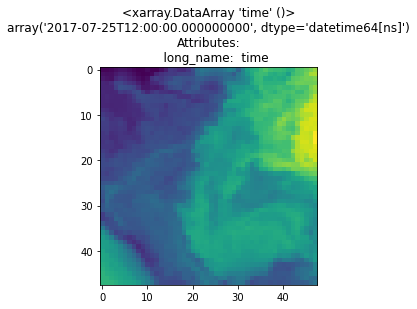

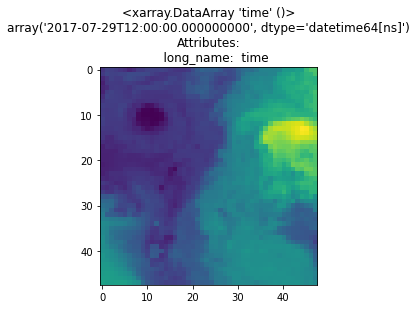

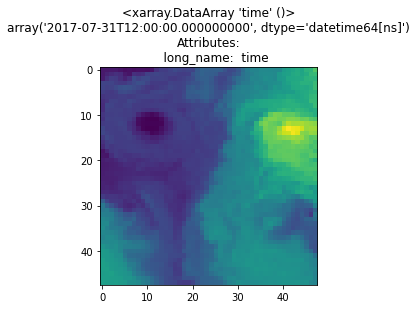

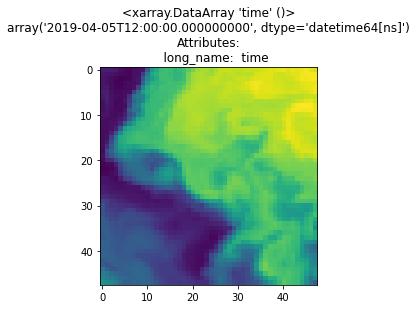

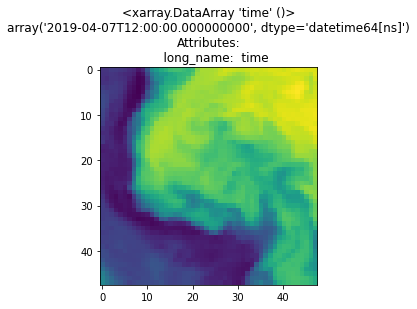

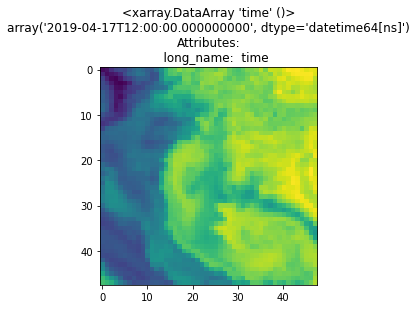

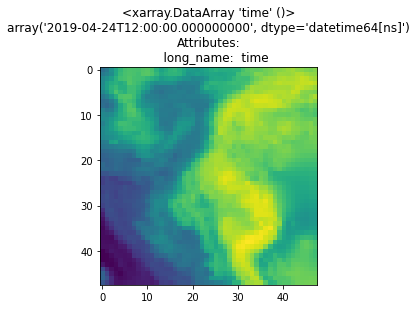

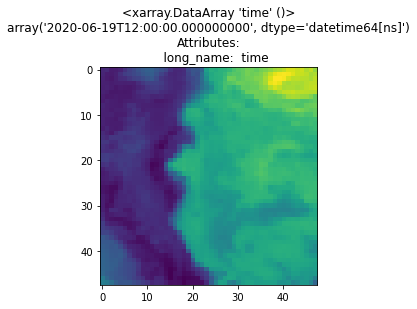

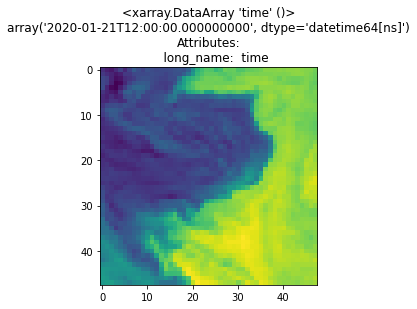

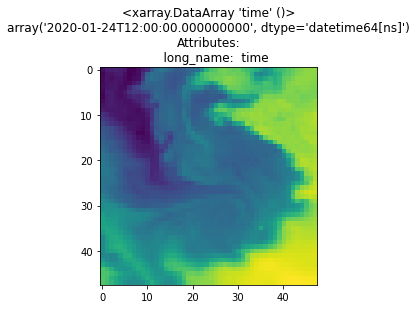

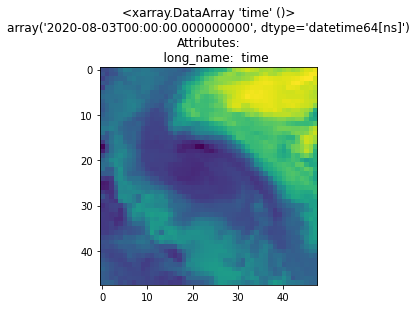

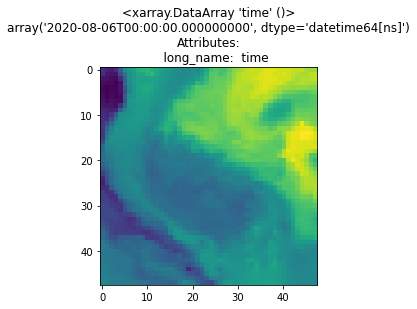

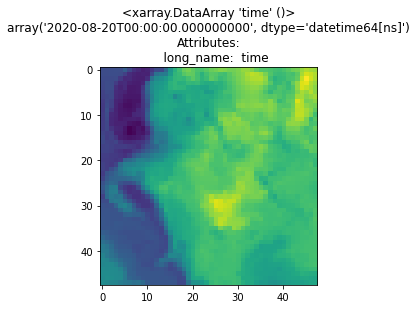

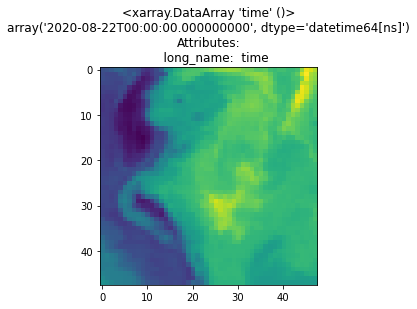

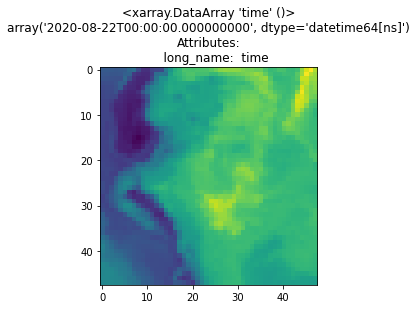

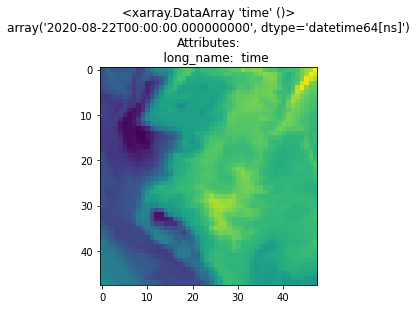

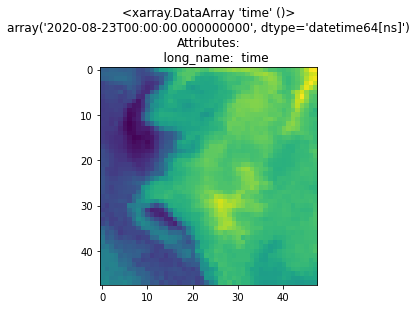

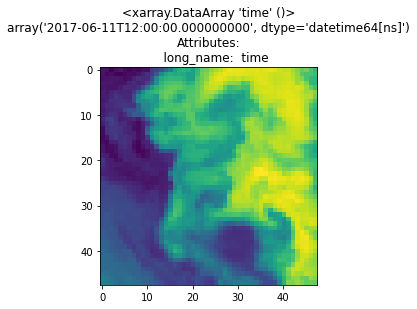

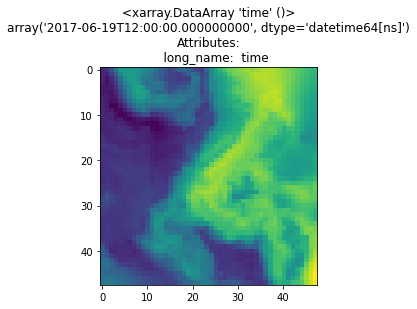

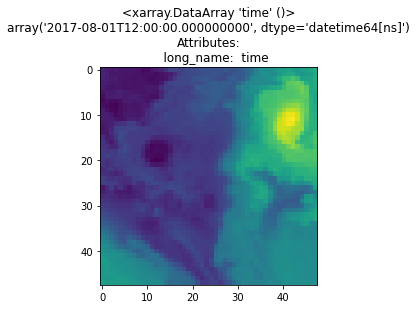

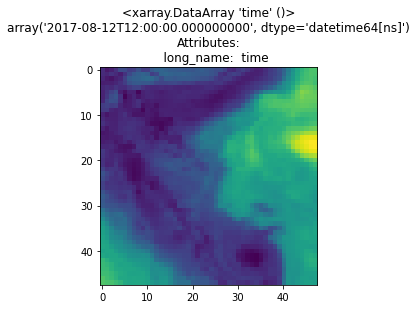

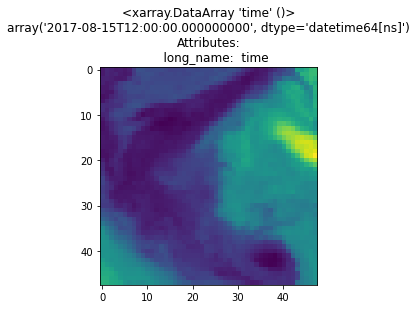

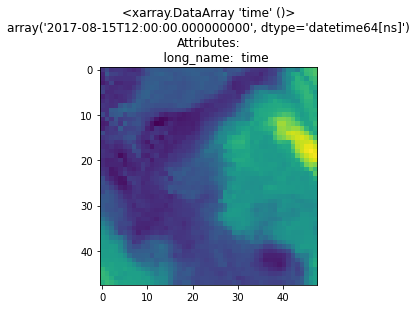

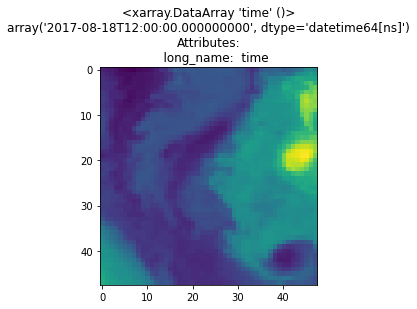

In [18]:
for i in range(len(ds.gRsst)): 
    plt.imshow(ds.gRsst .sel(i=i).data)
    plt.title(ds.time.sel(i=i))
    plt.show()

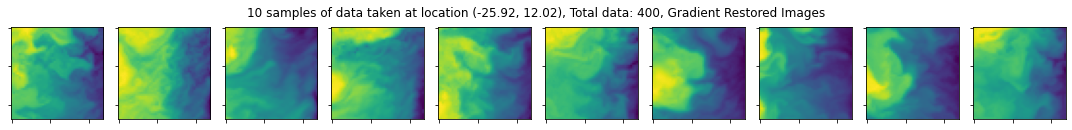

In [92]:
## Plot a sample of the data
N_samples = 10 
N_data = len(ds.gRsst)
sample_indices = np.random.randint(len(ds.gRsst), size = N_samples)
fig, ax = plt.subplots(1,10,figsize=(15,15))
for i, index in enumerate(sample_indices):
    ax[i].imshow(ds.gRsst.sel(i=index).data)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
fig.suptitle(f'{N_samples} samples of data taken at location {(round(grid[0],2),round(grid[1],2))}, Total data: {N_data}, Gradient Restored Images', y=0.55)
fig.tight_layout()
fig.savefig('plots/single_location_sample')
plt.show()

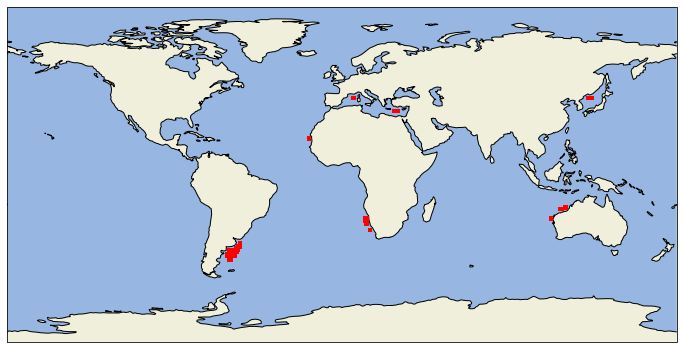

In [28]:
## Plot global map of top 50 data
x_min = -180
x_max = 180
y_min = -90
y_max = 90

fig = plt.figure(figsize=(12,24))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

for ((y0,x0,y1,x1),count) in top50:  
    col = "#FF0000FF"
    polygon = sgeom.Polygon(shell=[(x0,y0),(x1,y0),(x1,y1),(x0,y1)])
    ax.add_geometries([polygon], ccrs.PlateCarree(),facecolor=col)

plt.show()